# SAE on Normal NN MNIST

Testing further on the 512 hidden size version.

In [1]:
import time

EXPERIMENT_TYPE = "SAE"
RUN_ID = time.time()

## SAE Params

In [2]:
HIDDEN_SIZE = 512
L1_PENALTY = 0.3

## Imports

In [3]:
import random
import copy

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

In [4]:
from graph_helpers import (plot_weights,
                    plot_activations,
                    plot_losses,
                    plot_saliency_map,
                    plot_sparse_vecs_by_image,
                    plot_top_act_images_by_feature
                )

In [5]:
import sys, os
from pathlib import Path

# assume cwd is project_root/data_loader
project_root = Path(os.getcwd()).parent  # go up one level to project_root
sys.path.insert(0, str(project_root))

from helpers import load_images, load_labels, visualize_image, get_edges, generate_intermediate_edge_labels

## Set Device to GPU

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We will be using device: {device}")

We will be using device: cpu


## Load Data

In [7]:
# train data
train_images = load_images("../data/train-images-idx3-ubyte/train-images-idx3-ubyte")
train_labels = load_labels("../data/train-labels-idx1-ubyte/train-labels-idx1-ubyte")

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels,
    test_size=1/6,  # 10k validation
    stratify=train_labels,
    random_state=42  # for reproducibility
)

# test data
test_images = load_images("../data/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte")
test_labels = load_labels("../data/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")

In [8]:
print("Train images shape:", train_images.shape)
print("Val images shape:", val_images.shape)
print("Test images shape:", test_images.shape)

Train images shape: (50000, 28, 28)
Val images shape: (10000, 28, 28)
Test images shape: (10000, 28, 28)


## Visualize an image

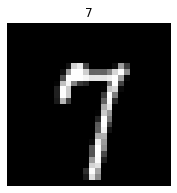

In [9]:
sample_image = train_images[0]
sample_label = train_labels[0]
visualize_image(sample_image, sample_label)

## Architecture

### NN

Once again, two hidden layers. 16 nodes each. Same as 3blue1brown.

In [10]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        layer_size_by_pixels = 28*28
        
        self.flatten = nn.Flatten()
        
        # define layers separately to have access to each
        self.hidden_one = nn.Linear(layer_size_by_pixels, 16)
        self.hidden_two = nn.Linear(16, 16)
        self.classification_layer = nn.Linear(16, 10)
        
        self.activation_function = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)

        # first hidden layer
        hidden_one_out = self.hidden_one(x)
        hidden_one_act = self.activation_function(hidden_one_out)

        # second hidden layer
        hidden_two_out = self.hidden_two(hidden_one_act)
        hidden_two_act = self.activation_function(hidden_two_out)

        # classification layer
        classification_out = self.classification_layer(hidden_two_act)
        
        return classification_out, hidden_one_act, hidden_two_act

In [11]:
# for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [12]:
model = NeuralNetwork().to(device)

# loss functions
classification_loss_fn = nn.CrossEntropyLoss()

# optimizers
optimizer = torch.optim.Adam(model.parameters())

In [13]:
print(f"Model weights (to compare below): {model.hidden_one.weight[0][:5].detach().cpu().numpy()}")

Model weights (to compare below): [ 0.02730495  0.02964314 -0.00836688  0.03280755 -0.00782513]


### SAE

In [14]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_size=16, hidden_size=128):
        super().__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        encoded = self.activation(self.encoder(x))
        reconstructed = self.decoder(encoded)
        return reconstructed, encoded
    
    def loss(self, x, reconstructed, encoded, l1_lambda=0.001):
        mse_loss = nn.MSELoss()(reconstructed, x)
        l1_loss = l1_lambda * torch.mean(torch.abs(encoded))
        return mse_loss + l1_loss

In [15]:
# for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
sae_hidden_two = SparseAutoencoder(input_size=16, hidden_size=HIDDEN_SIZE).to(device)
optimizer_sae_hidden_two = torch.optim.Adam(sae_hidden_two.parameters())

In [16]:
# expectation: SAE weights: [ 0.19113463  0.20750198 -0.05856812  0.22965282 -0.05477589]
print(f"SAE weights: {sae_hidden_two.encoder.weight[0][:5].detach().cpu().numpy()}")

SAE weights: [ 0.19113463  0.20750198 -0.05856812  0.22965282 -0.05477589]


In [17]:
# for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
sae_hidden_one = SparseAutoencoder(input_size=16, hidden_size=HIDDEN_SIZE).to(device)
optimizer_sae_hidden_one = torch.optim.Adam(sae_hidden_one.parameters())

In [18]:
# expectation: SAE weights: [ 0.19113463  0.20750198 -0.05856812  0.22965282 -0.05477589]
print(f"SAE weights: {sae_hidden_one.encoder.weight[0][:5].detach().cpu().numpy()}")

SAE weights: [ 0.19113463  0.20750198 -0.05856812  0.22965282 -0.05477589]


### Verify Reproducibility

In [19]:
# reset the seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    
model_compare_one = NeuralNetwork().to(device)
first_set_of_weights = model_compare_one.hidden_one.weight[0][:5].detach().cpu().numpy()
print("First set of weights:", first_set_of_weights)

# reset the seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

model_compare_two = NeuralNetwork().to(device)
second_set_of_weights = model_compare_two.hidden_one.weight[0][:5].detach().cpu().numpy()
print("Second set of weights:", second_set_of_weights)

print(f"Are the two sets equal: {first_set_of_weights == second_set_of_weights}")

First set of weights: [ 0.02730495  0.02964314 -0.00836688  0.03280755 -0.00782513]
Second set of weights: [ 0.02730495  0.02964314 -0.00836688  0.03280755 -0.00782513]
Are the two sets equal: [ True  True  True  True  True]


## Dataloader

In [20]:
class EdgeDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        assert len(self.images) == len(self.labels)
        return len(self.images)

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.images[idx].copy()).float(),
            torch.tensor(self.labels[idx].copy(), dtype=torch.long),
        )

In [21]:
# for reproducibility on training
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

generator = torch.Generator().manual_seed(seed)

In [22]:
NUM_WORKERS = 4
if device.type.lower() == "cpu":
    NUM_WORKERS = 0

# training data
train_dataset = EdgeDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=NUM_WORKERS, worker_init_fn=seed_worker, generator=generator)

# validation data
val_dataset = EdgeDataset(val_images, val_labels)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=NUM_WORKERS)  # larger batch size for faster validation

# test data
test_dataset = EdgeDataset(test_images, test_labels)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=NUM_WORKERS)

## Training Loop

Epoch 1/20
  Train Loss: 1.0131
  SAE Train Loss (hidden one): 8.9857
  SAE Train Loss (hidden two): 1.4461
  Val Loss: 0.5521 | Val Acc: 83.76%
  Saved model with Val Acc: 83.76%


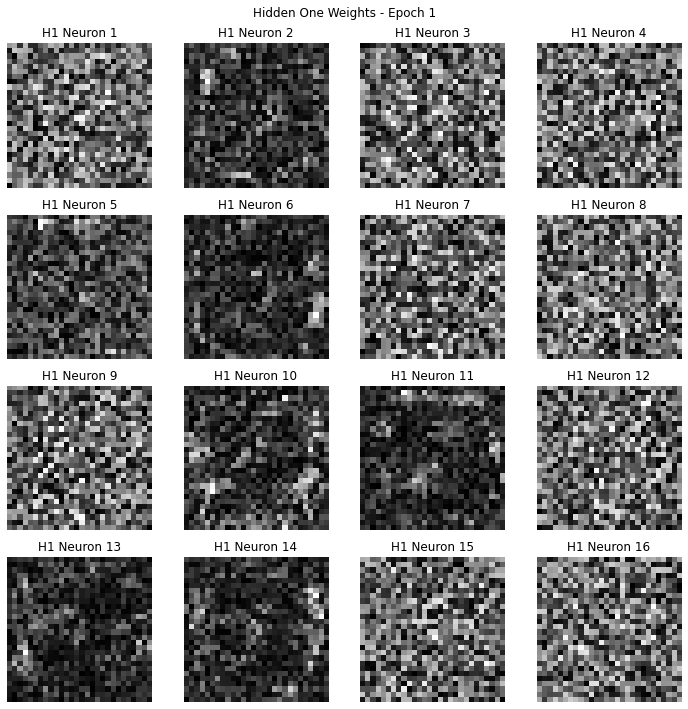

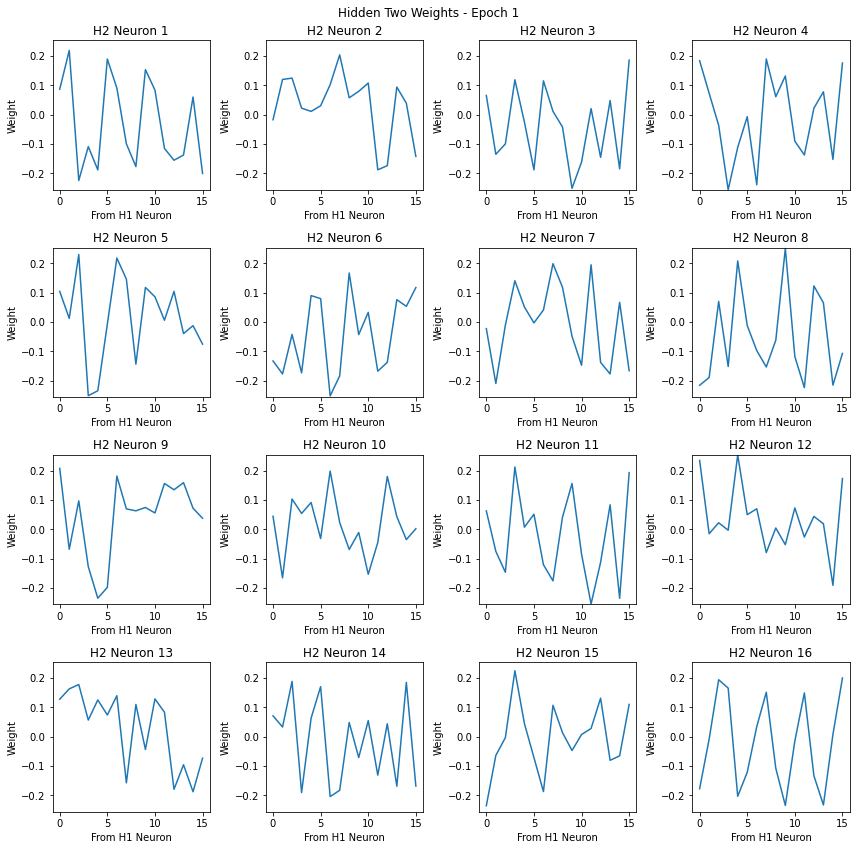

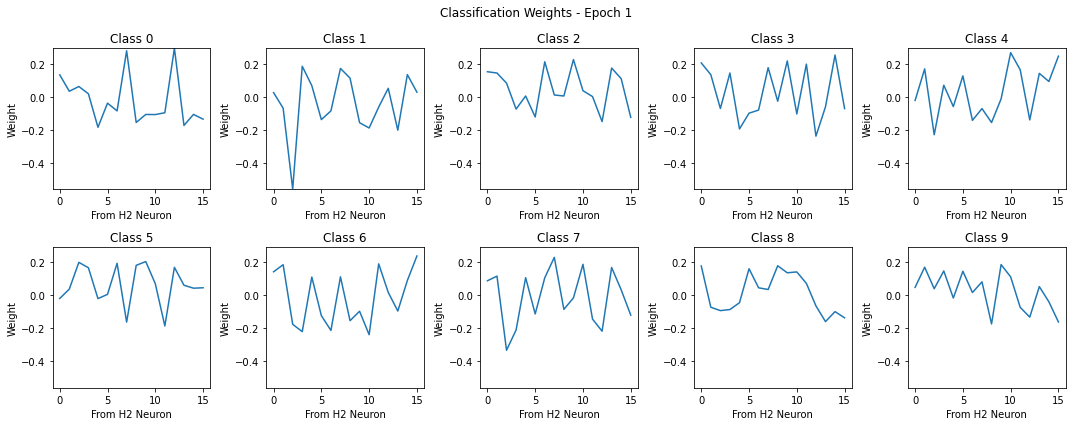

Epoch 2/20
  Train Loss: 0.4601
  SAE Train Loss (hidden one): 2.9089
  SAE Train Loss (hidden two): 0.4892
  Val Loss: 0.4512 | Val Acc: 86.42%
  Saved model with Val Acc: 86.42%


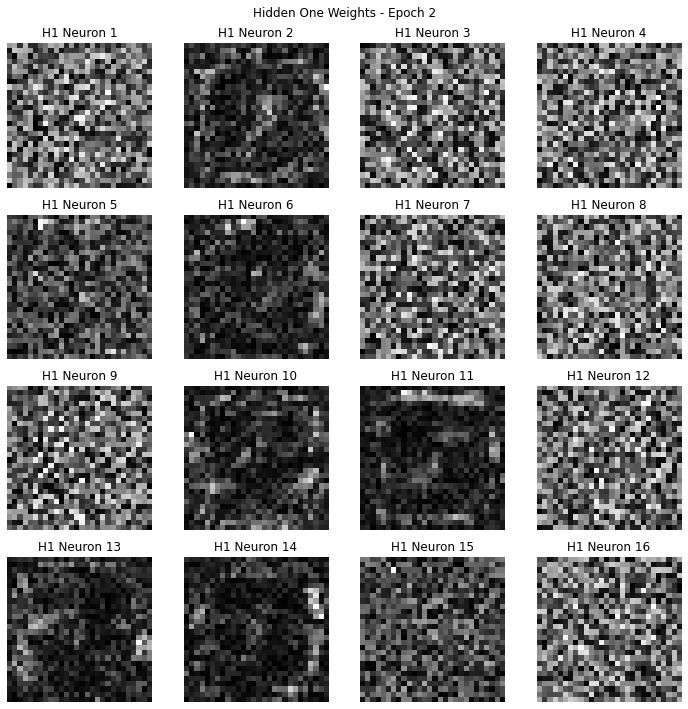

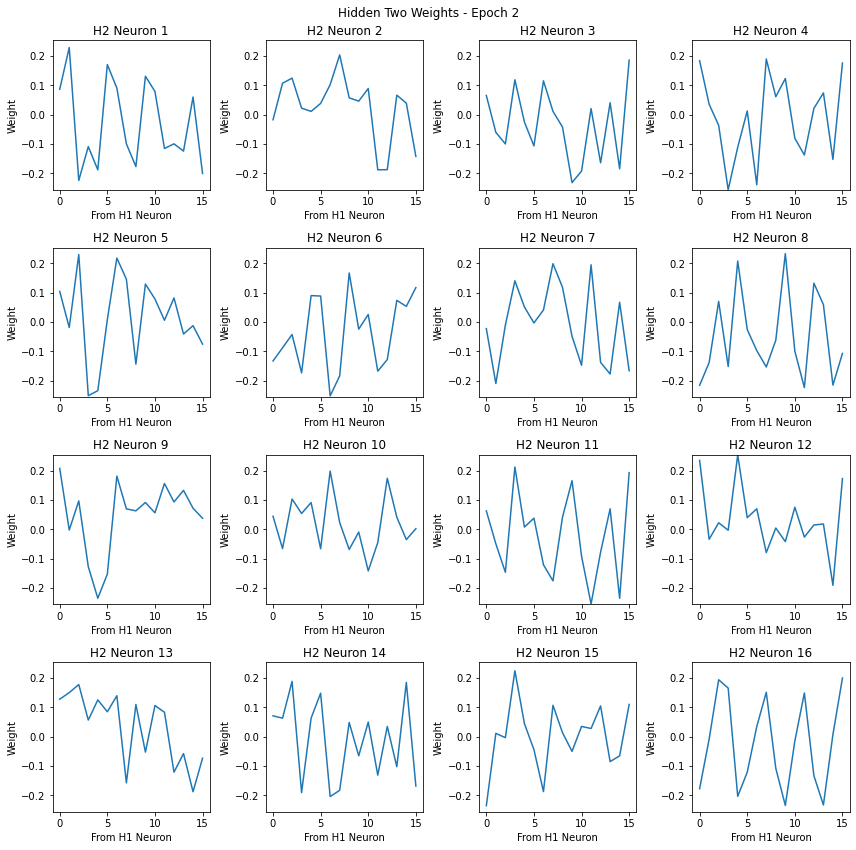

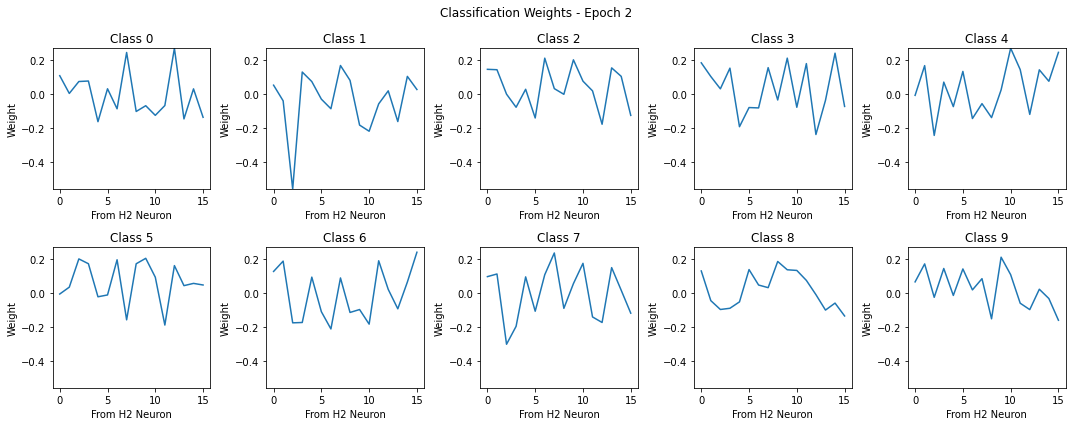

Epoch 3/20
  Train Loss: 0.4093
  SAE Train Loss (hidden one): 2.4353
  SAE Train Loss (hidden two): 0.3319
  Val Loss: 0.4022 | Val Acc: 87.76%
  Saved model with Val Acc: 87.76%


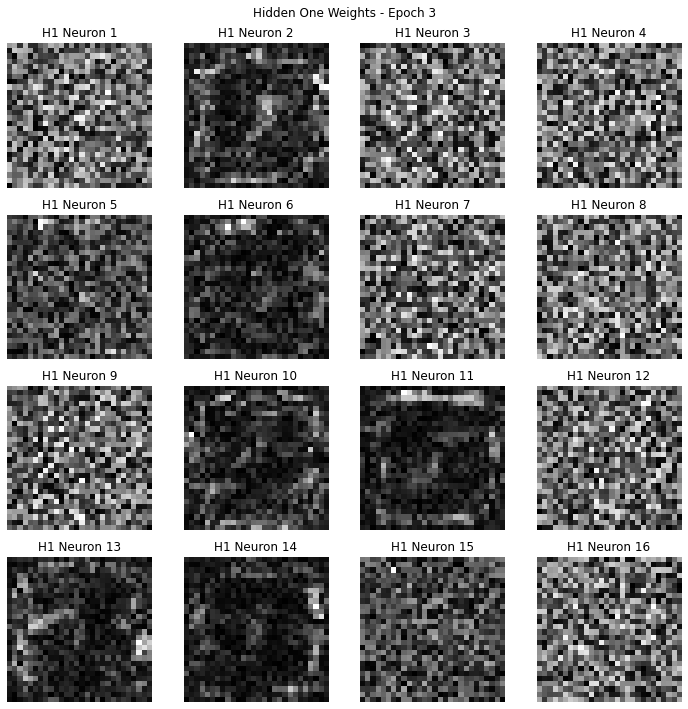

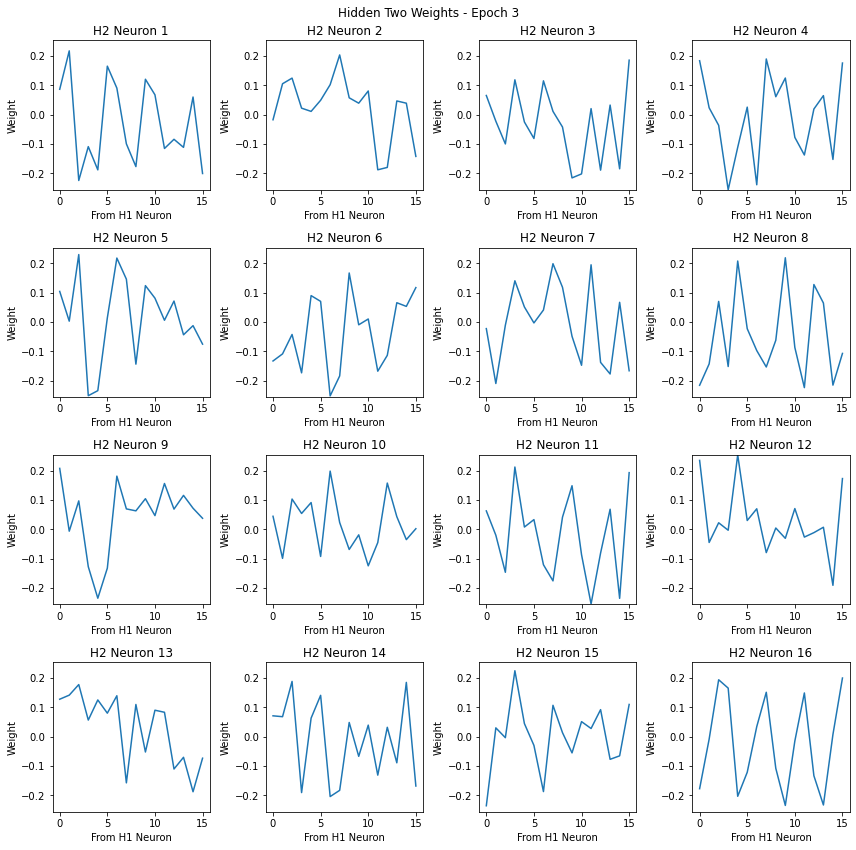

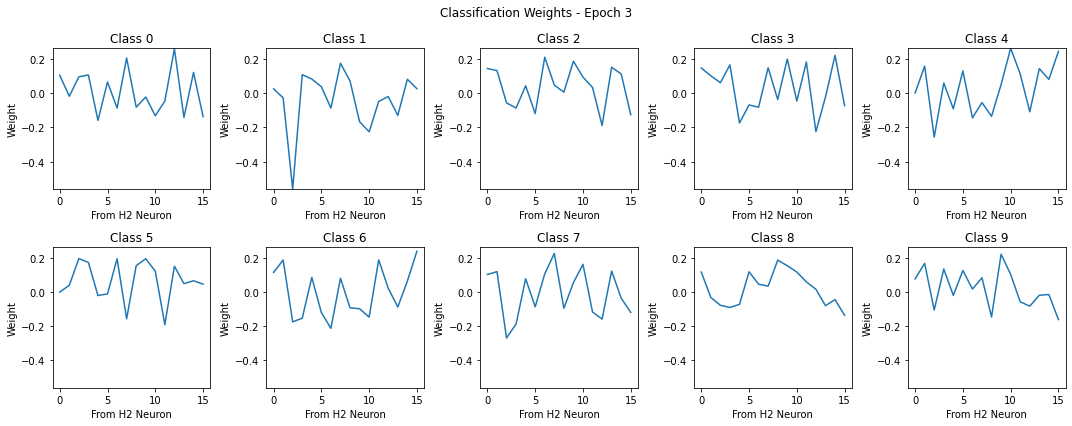

Epoch 4/20
  Train Loss: 0.3899
  SAE Train Loss (hidden one): 2.1690
  SAE Train Loss (hidden two): 0.2680
  Val Loss: 0.4044 | Val Acc: 87.80%
  Saved model with Val Acc: 87.80%


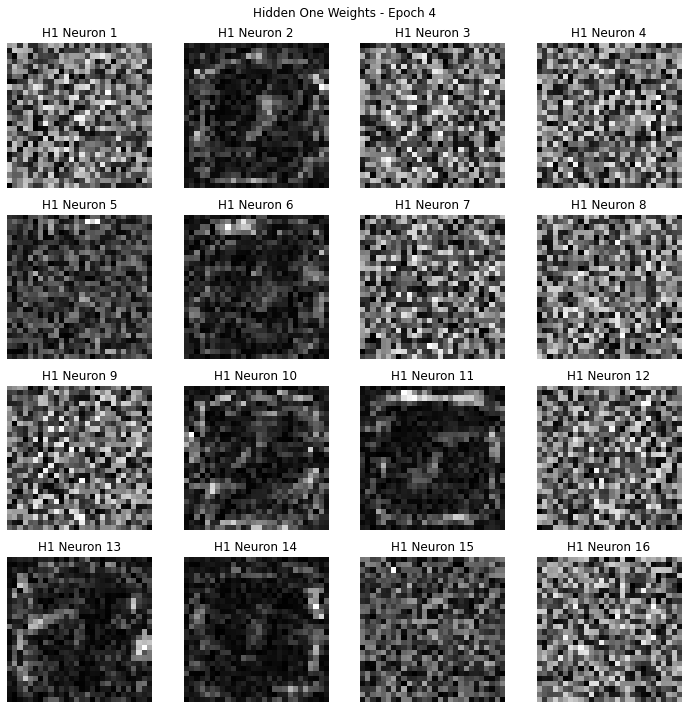

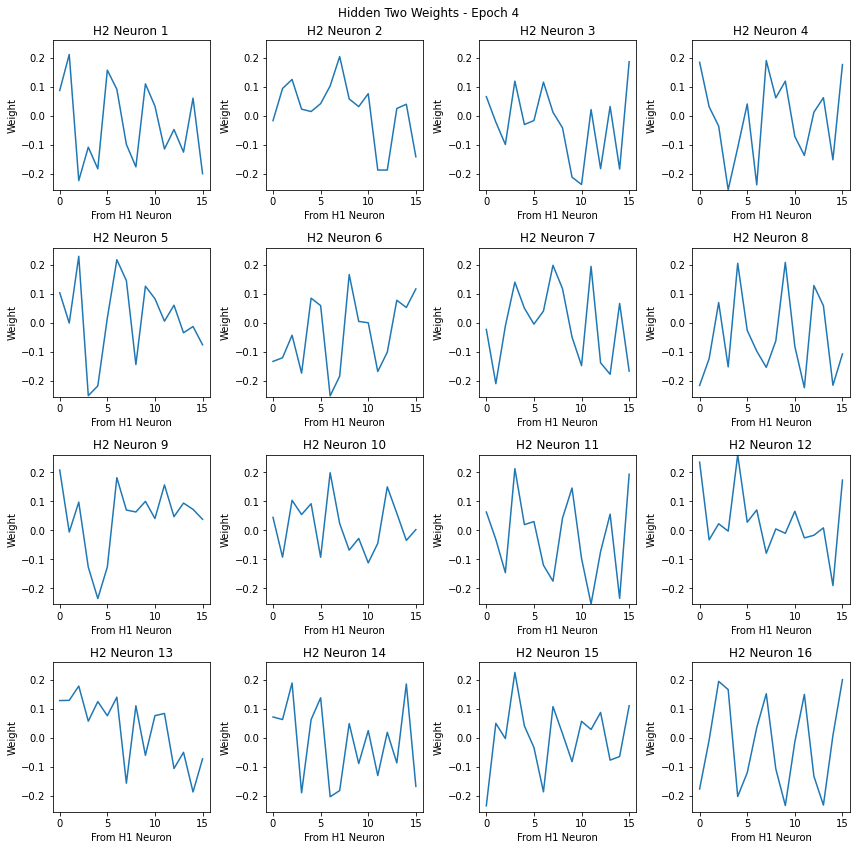

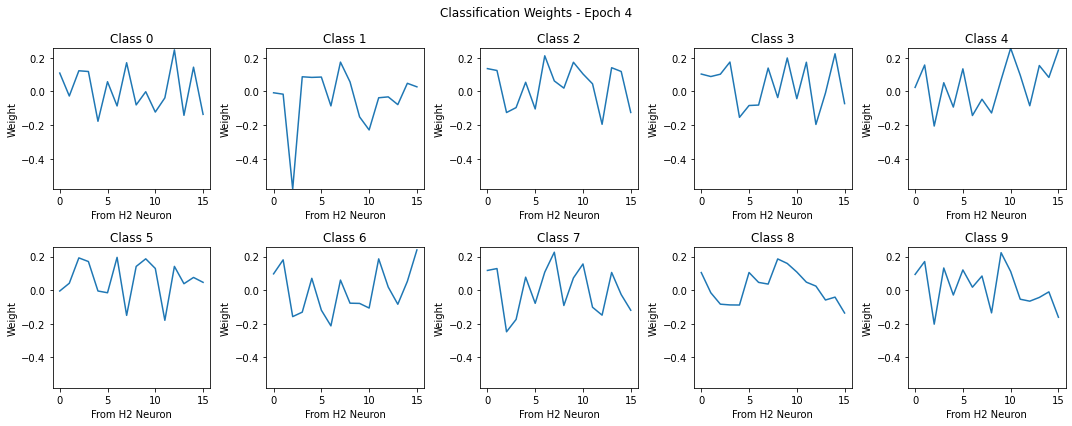

Epoch 5/20
  Train Loss: 0.3708
  SAE Train Loss (hidden one): 2.0194
  SAE Train Loss (hidden two): 0.2389
  Val Loss: 0.3718 | Val Acc: 88.68%
  Saved model with Val Acc: 88.68%


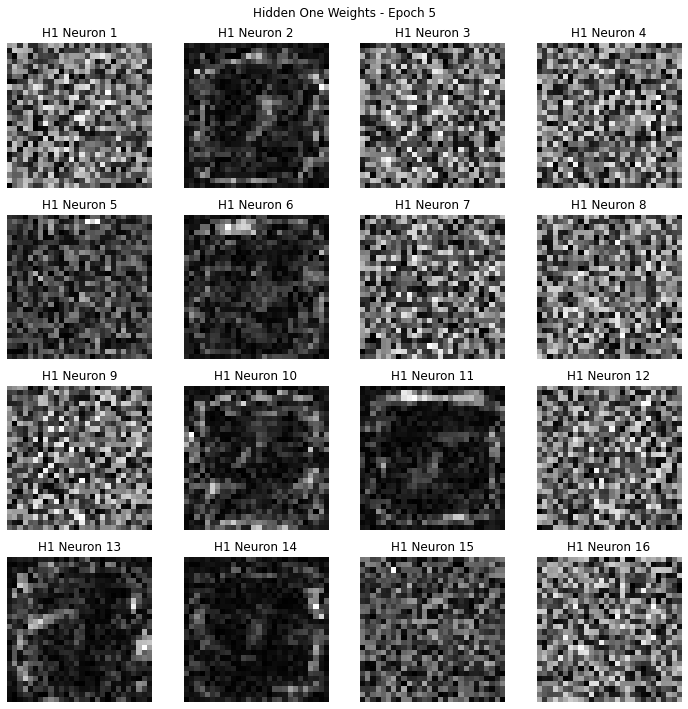

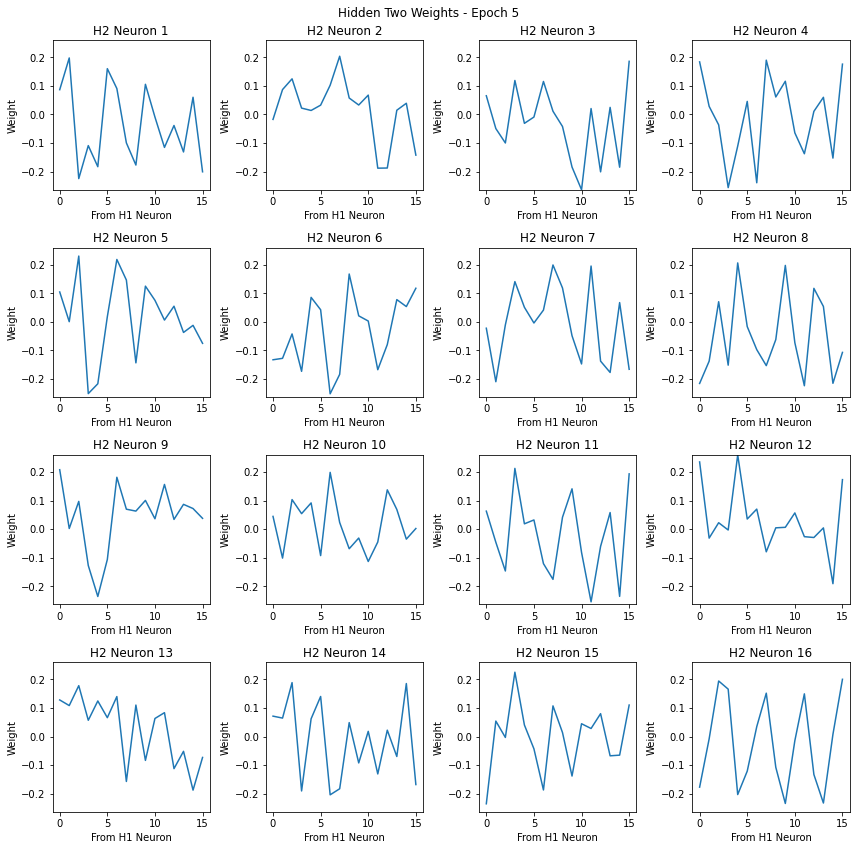

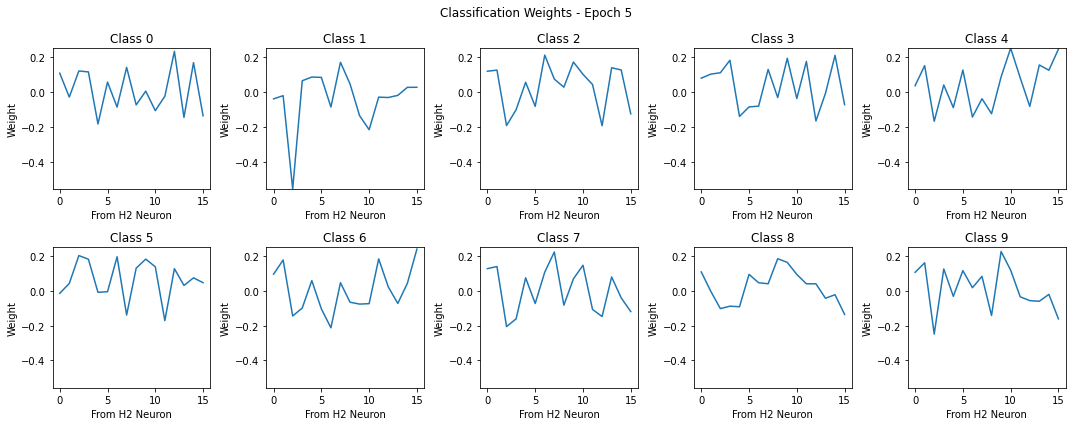

Epoch 6/20
  Train Loss: 0.3590
  SAE Train Loss (hidden one): 1.9192
  SAE Train Loss (hidden two): 0.2164
  Val Loss: 0.3640 | Val Acc: 89.51%
  Saved model with Val Acc: 89.51%


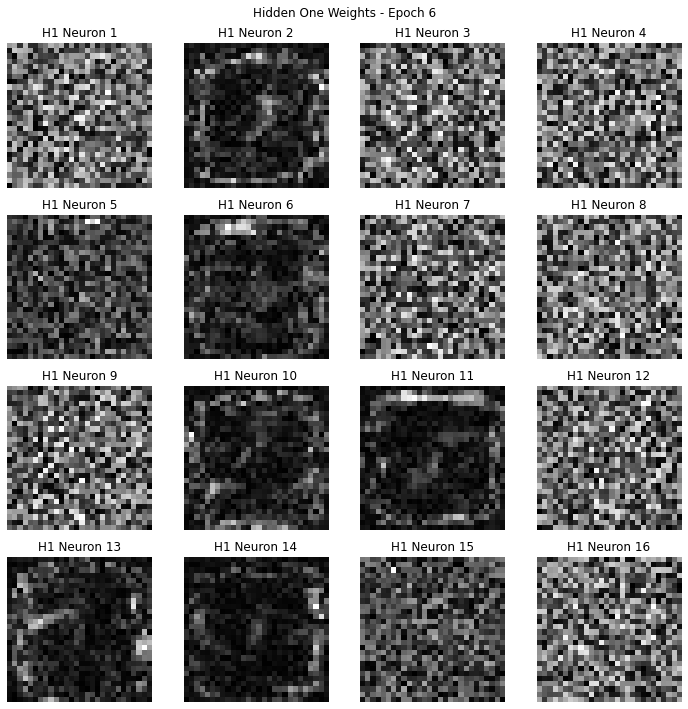

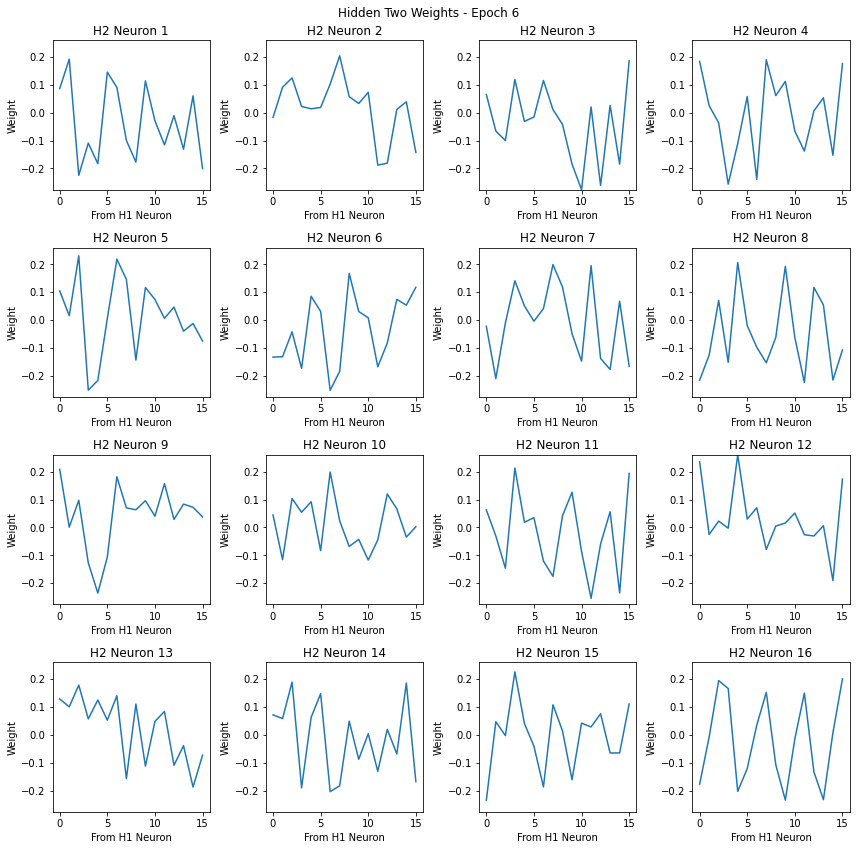

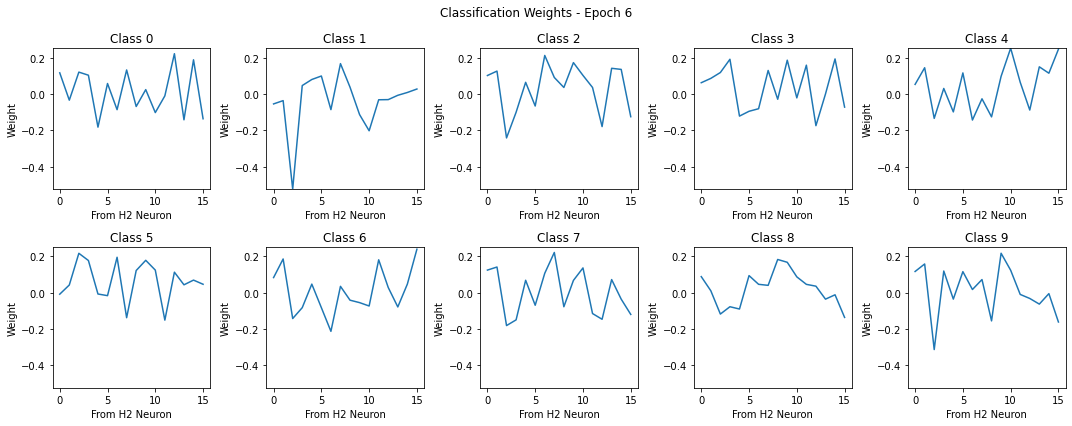

Epoch 7/20
  Train Loss: 0.3511
  SAE Train Loss (hidden one): 1.8450
  SAE Train Loss (hidden two): 0.2028
  Val Loss: 0.3932 | Val Acc: 88.37%


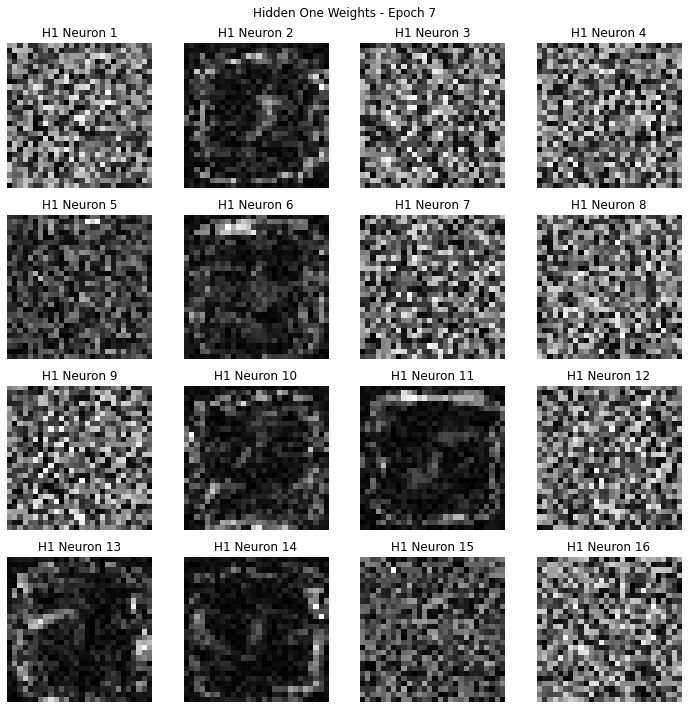

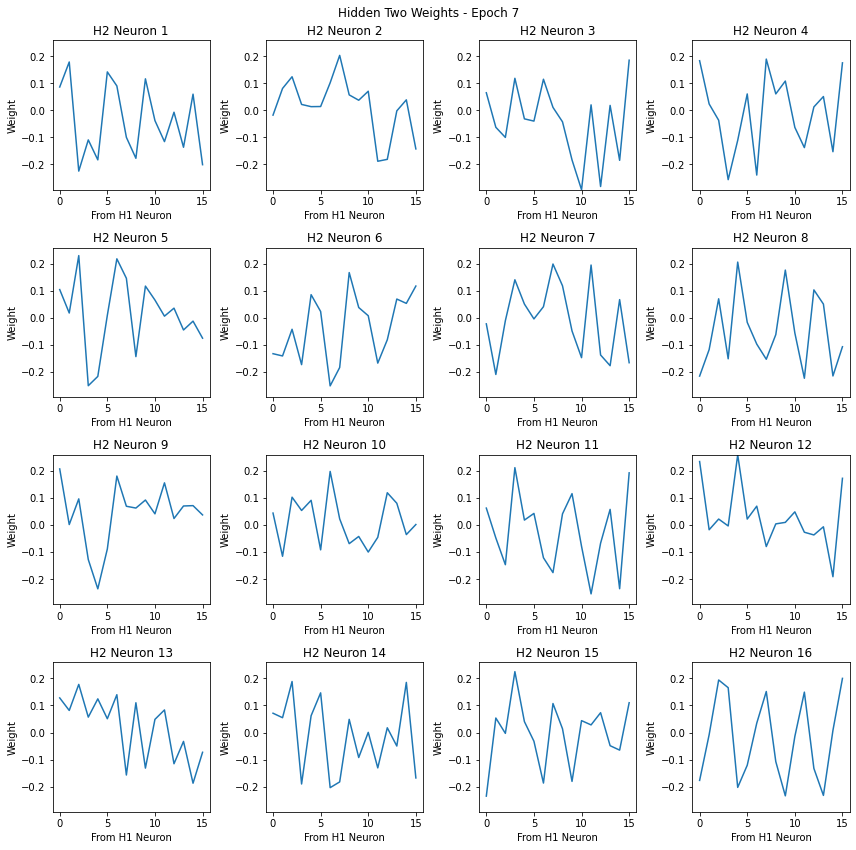

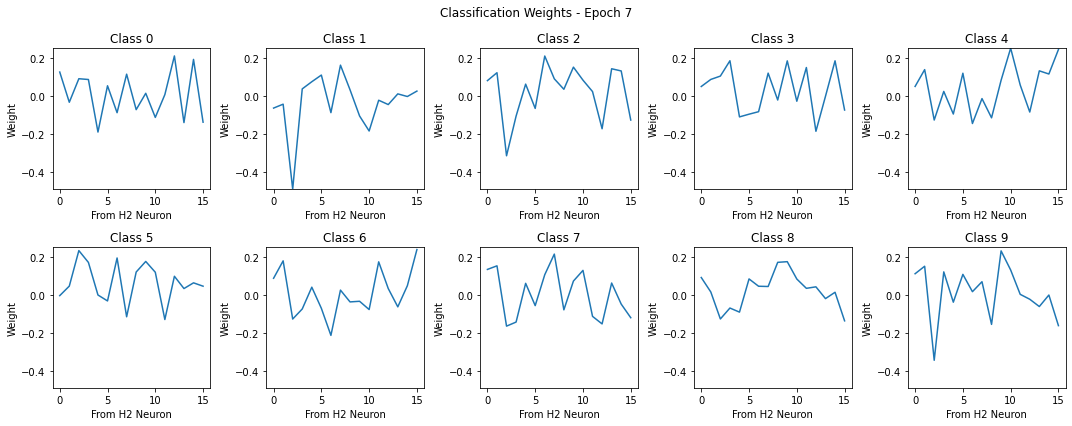

Epoch 8/20
  Train Loss: 0.3440
  SAE Train Loss (hidden one): 1.8085
  SAE Train Loss (hidden two): 0.1912
  Val Loss: 0.3642 | Val Acc: 89.00%


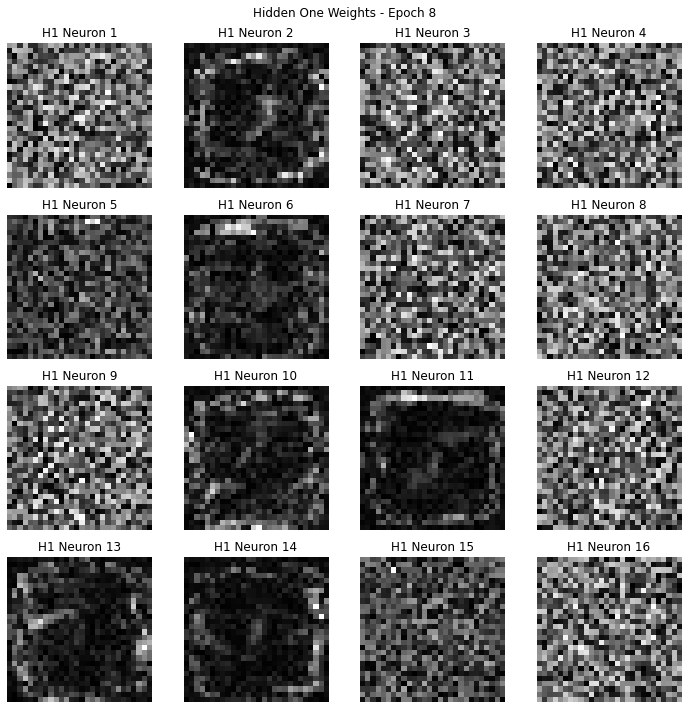

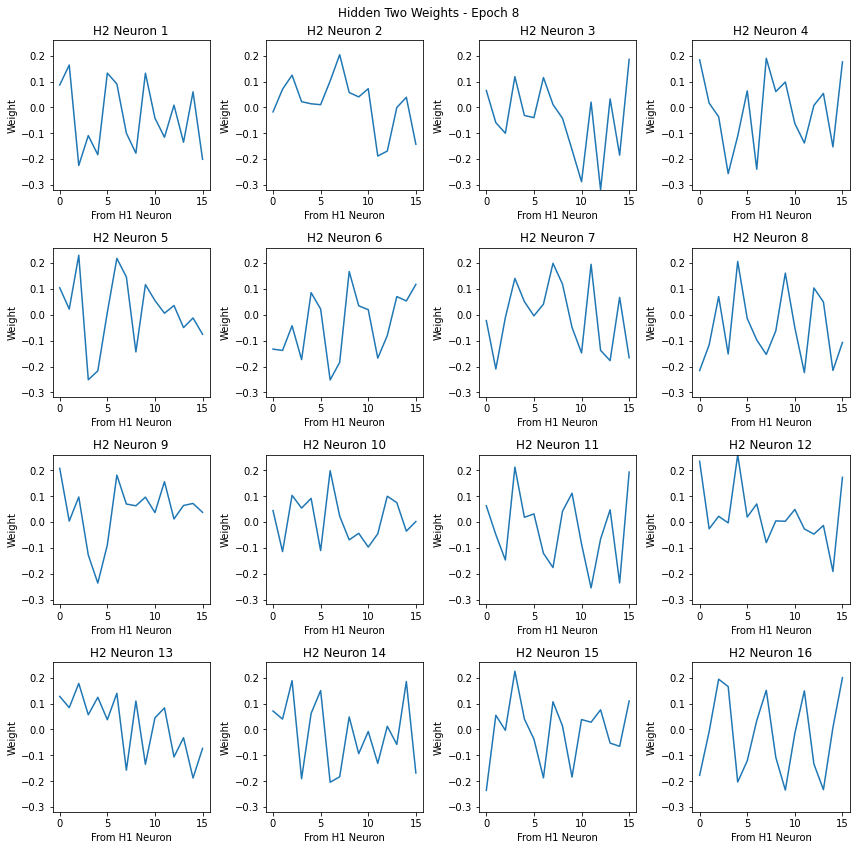

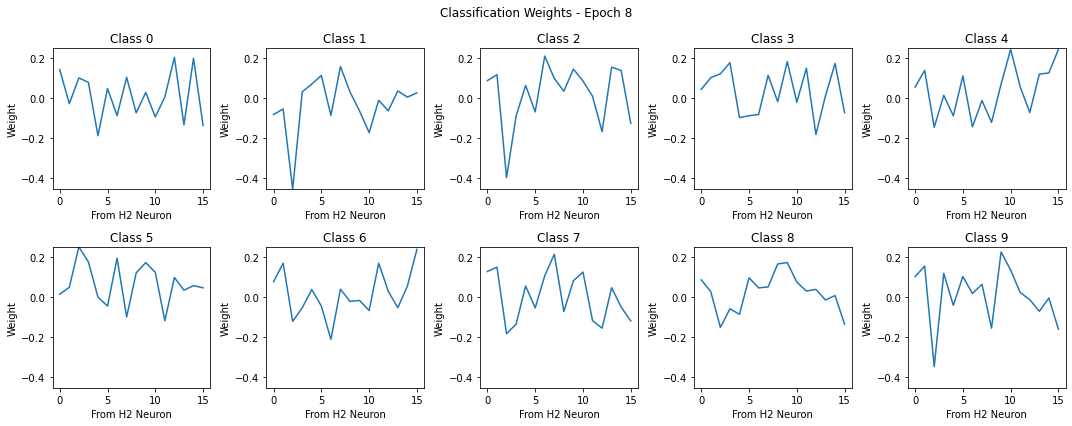

Epoch 9/20
  Train Loss: 0.3392
  SAE Train Loss (hidden one): 1.7735
  SAE Train Loss (hidden two): 0.1841
  Val Loss: 0.3668 | Val Acc: 89.01%


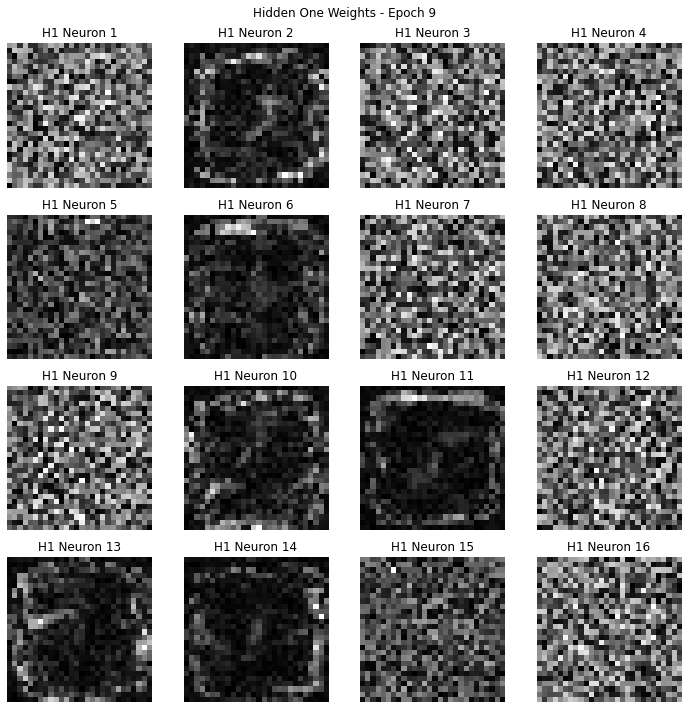

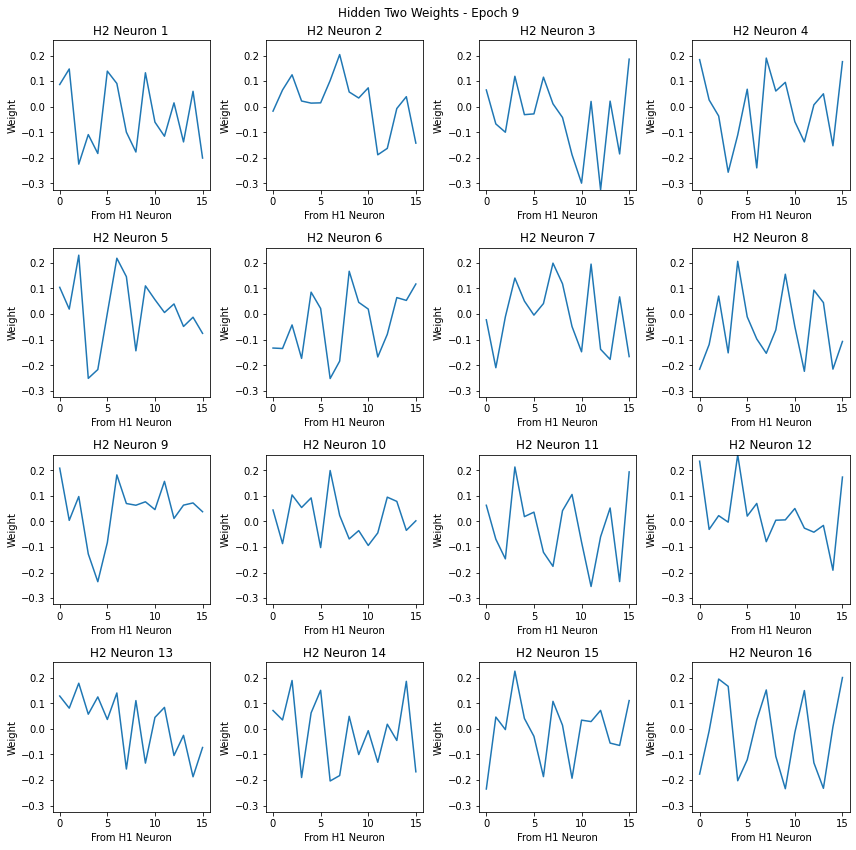

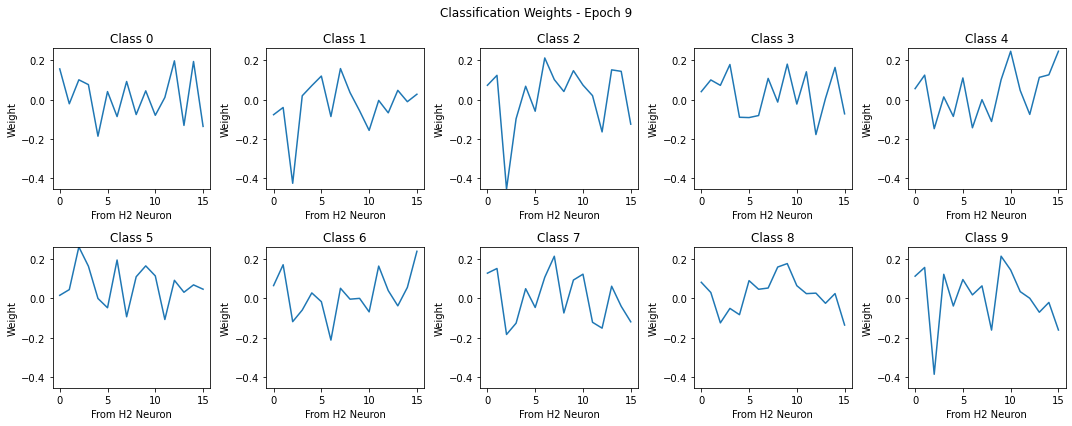

Epoch 10/20
  Train Loss: 0.3337
  SAE Train Loss (hidden one): 1.7759
  SAE Train Loss (hidden two): 0.1734
  Val Loss: 0.3616 | Val Acc: 89.52%
  Saved model with Val Acc: 89.52%


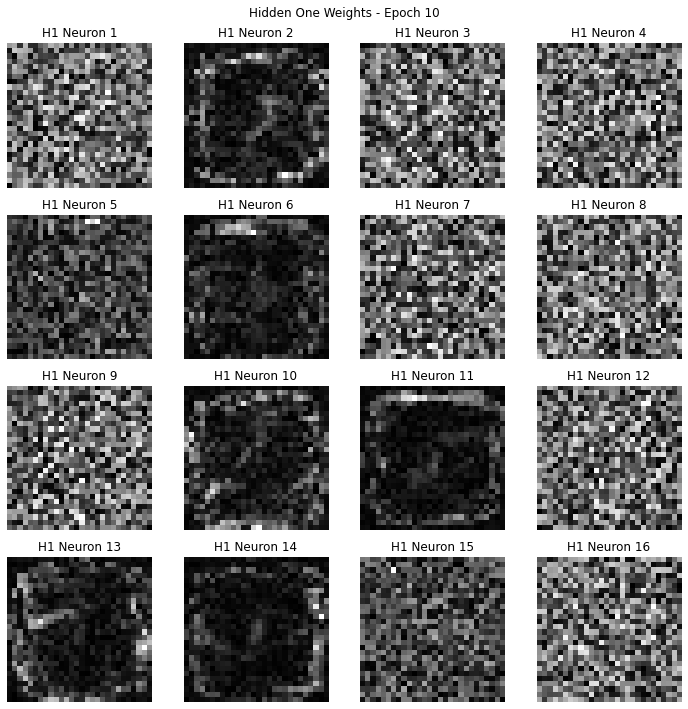

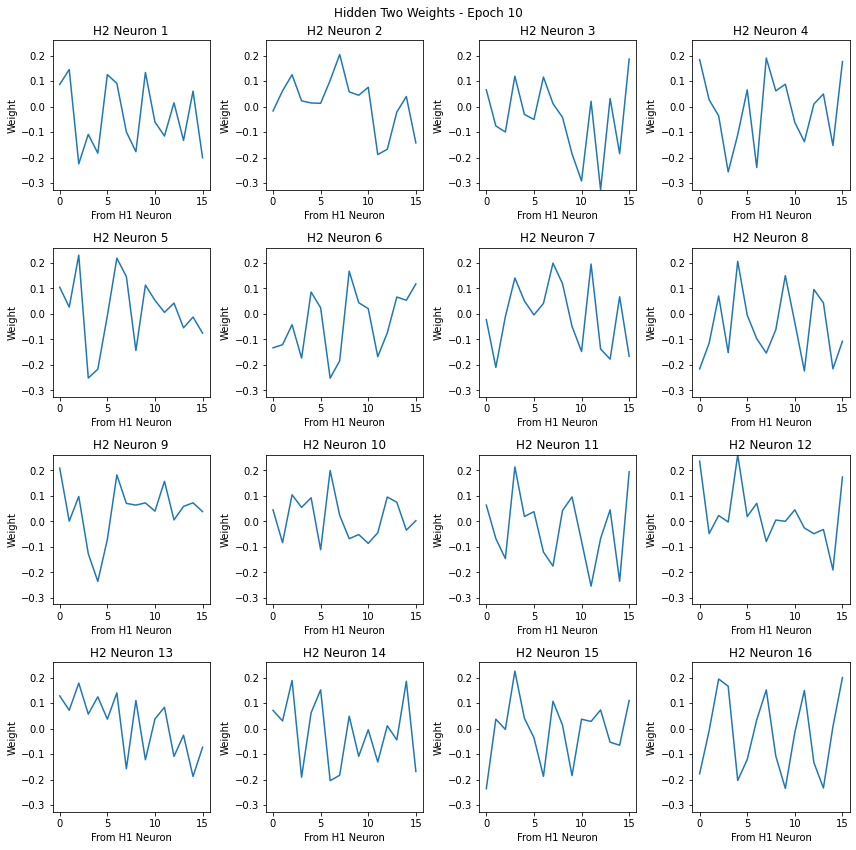

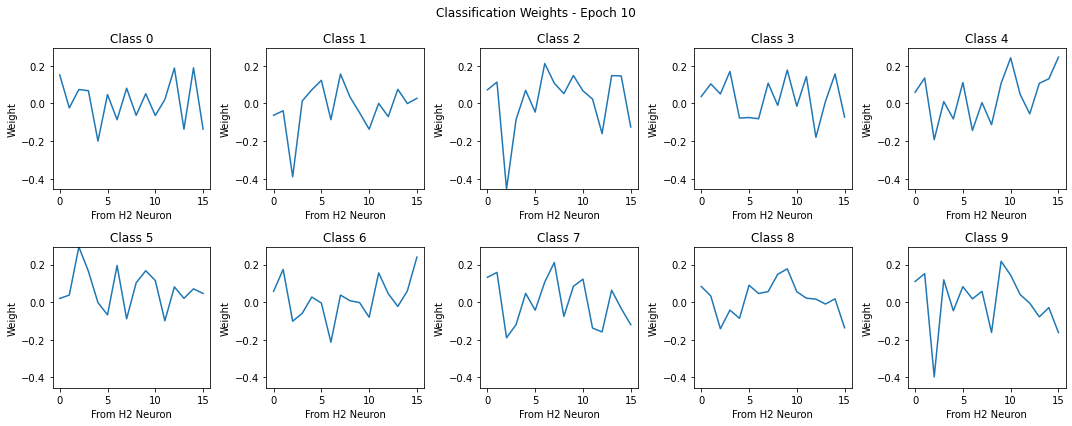

Epoch 11/20
  Train Loss: 0.3278
  SAE Train Loss (hidden one): 1.7494
  SAE Train Loss (hidden two): 0.1688
  Val Loss: 0.3636 | Val Acc: 89.26%


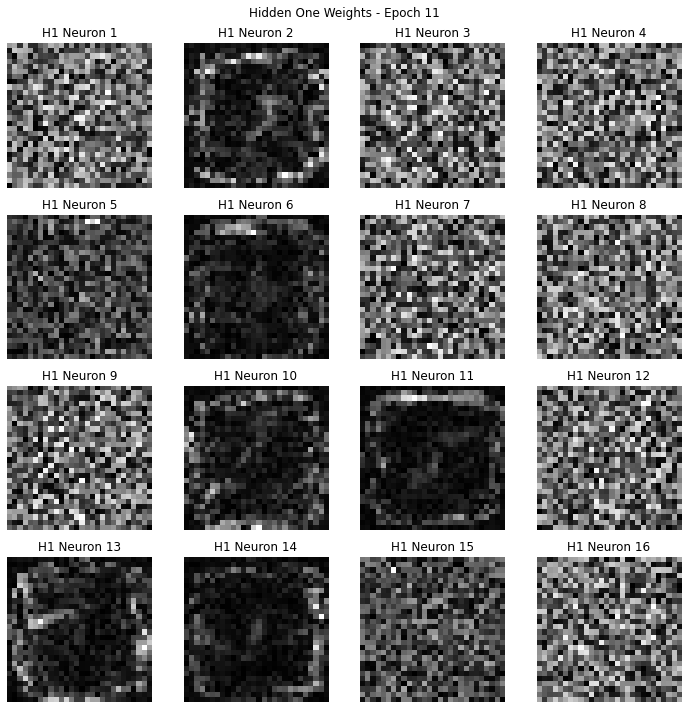

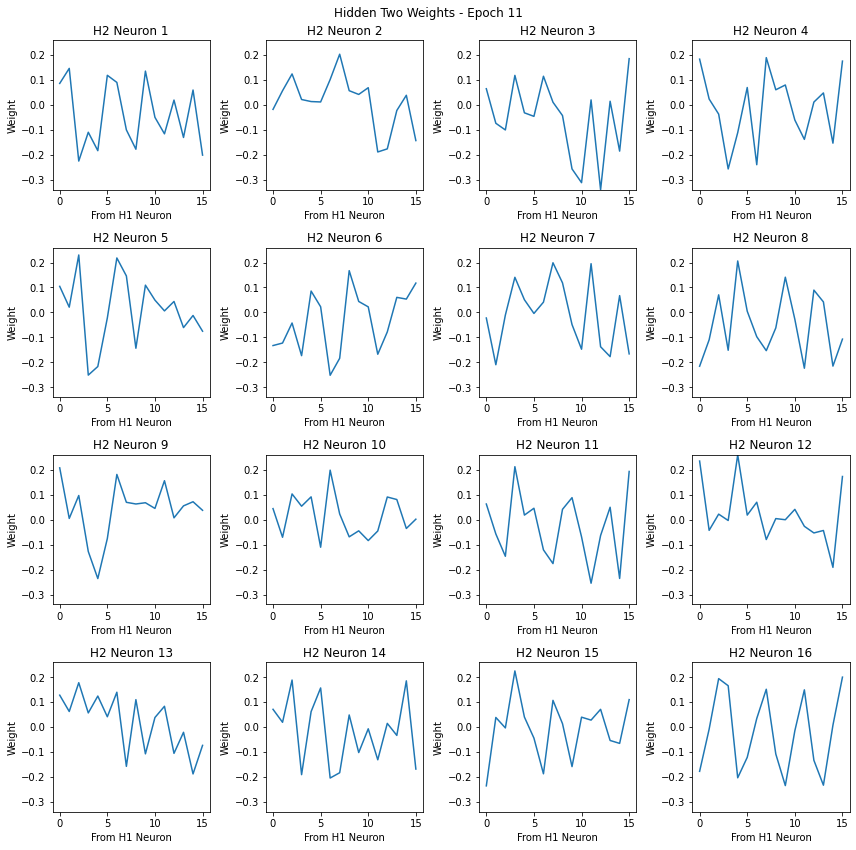

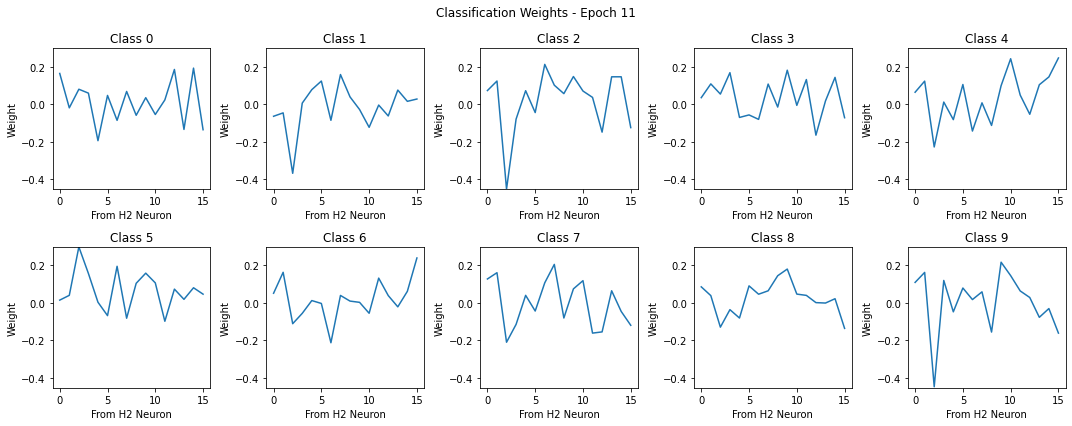

Epoch 12/20
  Train Loss: 0.3276
  SAE Train Loss (hidden one): 1.7420
  SAE Train Loss (hidden two): 0.1603
  Val Loss: 0.3588 | Val Acc: 89.54%
  Saved model with Val Acc: 89.54%


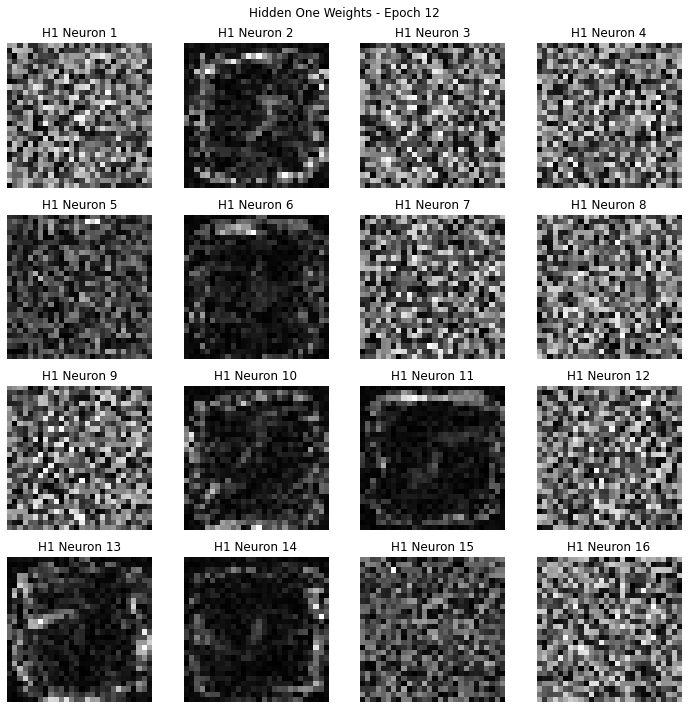

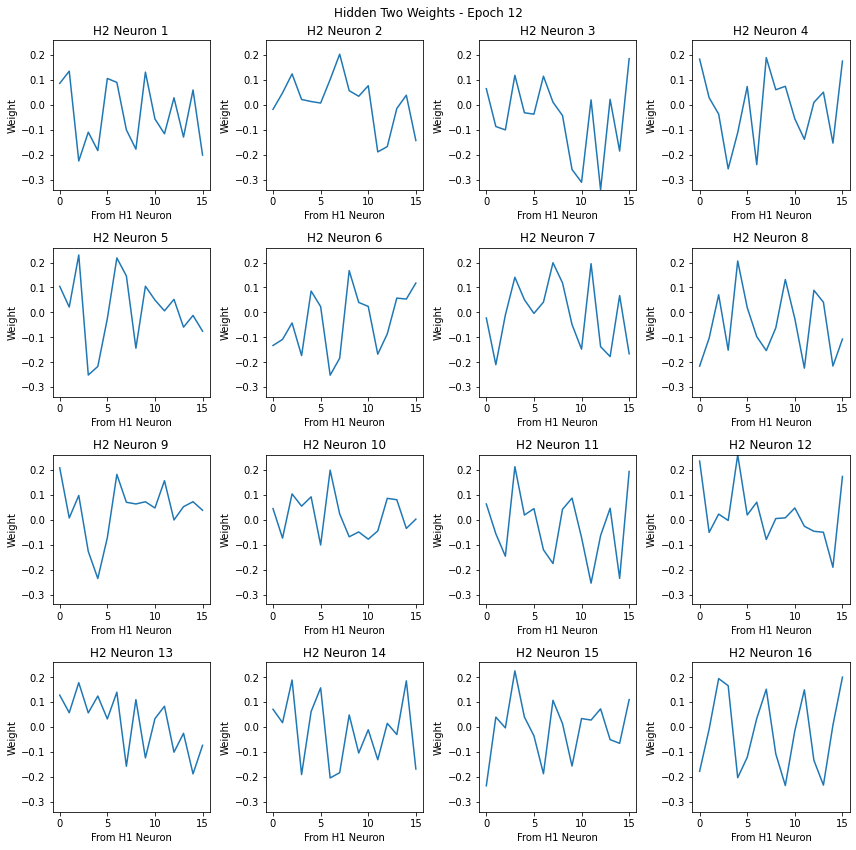

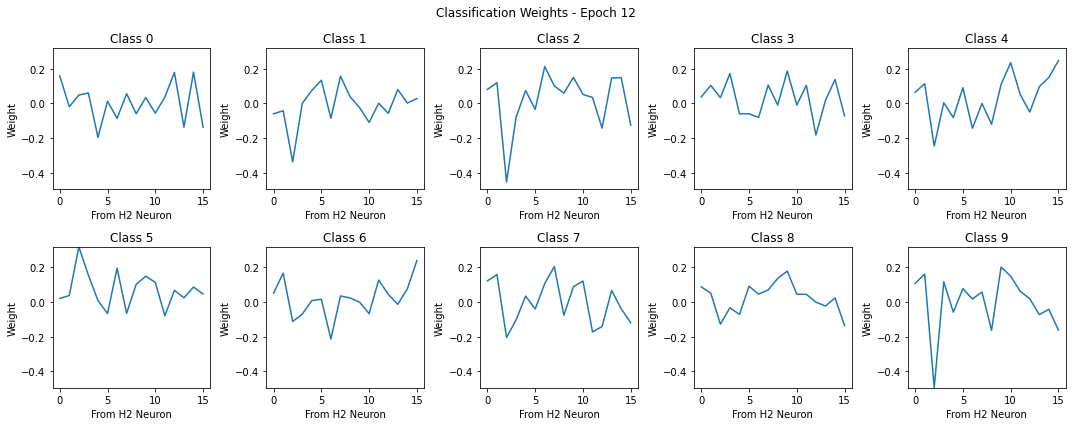

Epoch 13/20
  Train Loss: 0.3246
  SAE Train Loss (hidden one): 1.7059
  SAE Train Loss (hidden two): 0.1535
  Val Loss: 0.3596 | Val Acc: 89.44%


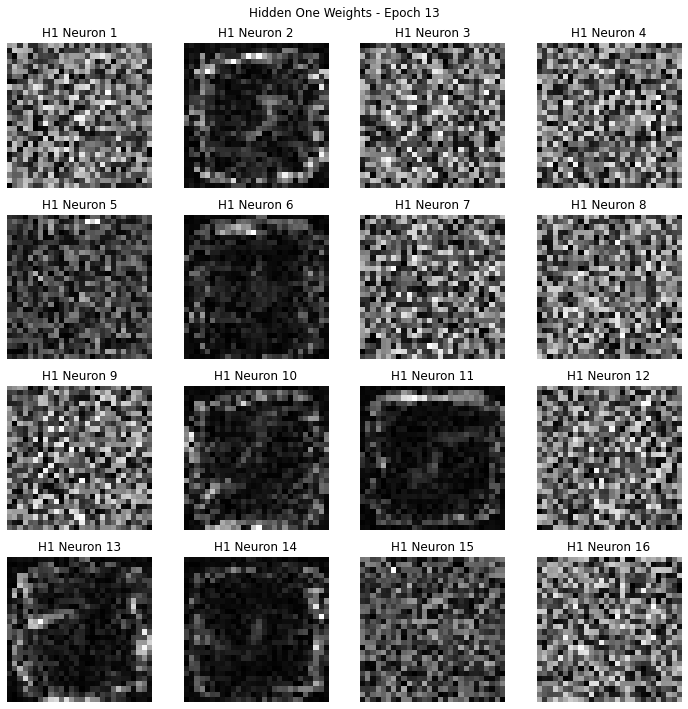

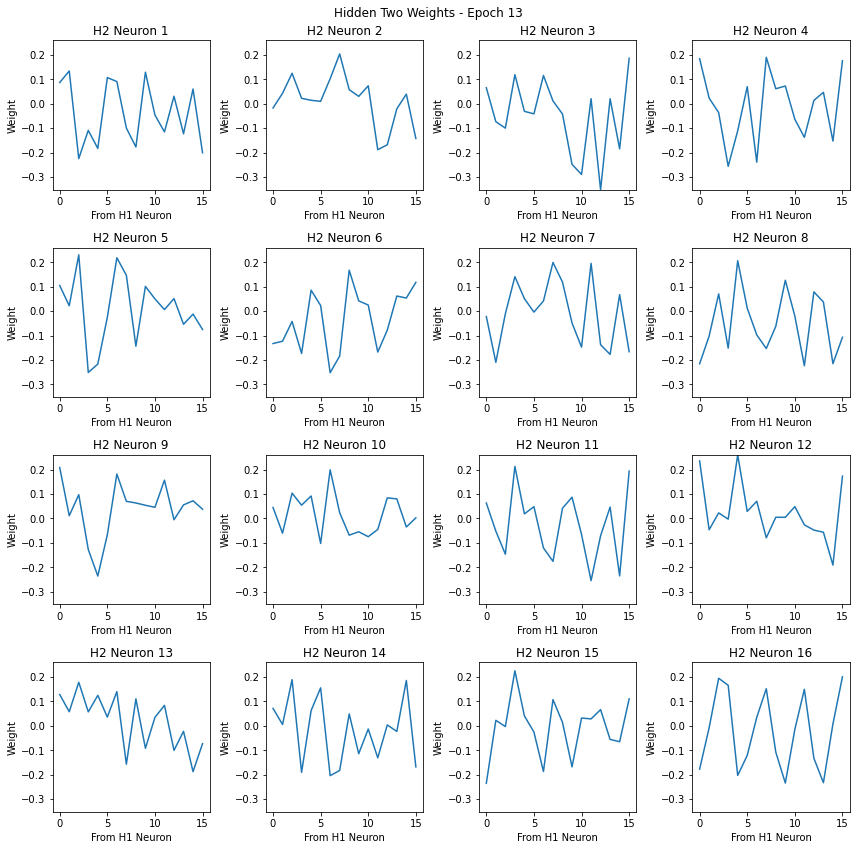

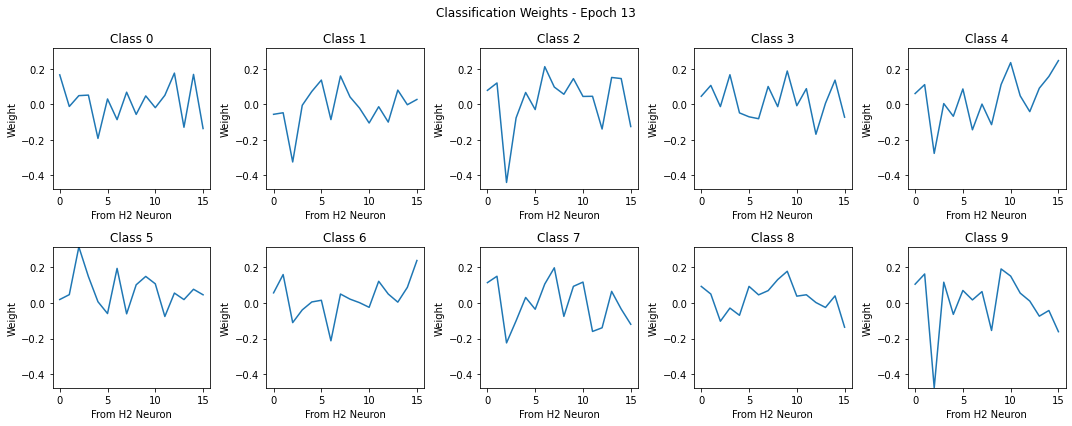

Epoch 14/20
  Train Loss: 0.3221
  SAE Train Loss (hidden one): 1.6948
  SAE Train Loss (hidden two): 0.1447
  Val Loss: 0.3644 | Val Acc: 89.28%


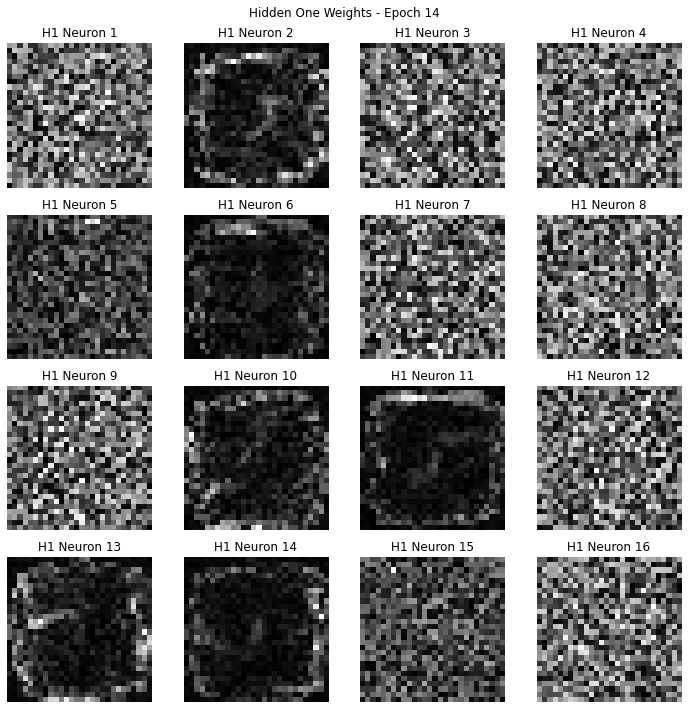

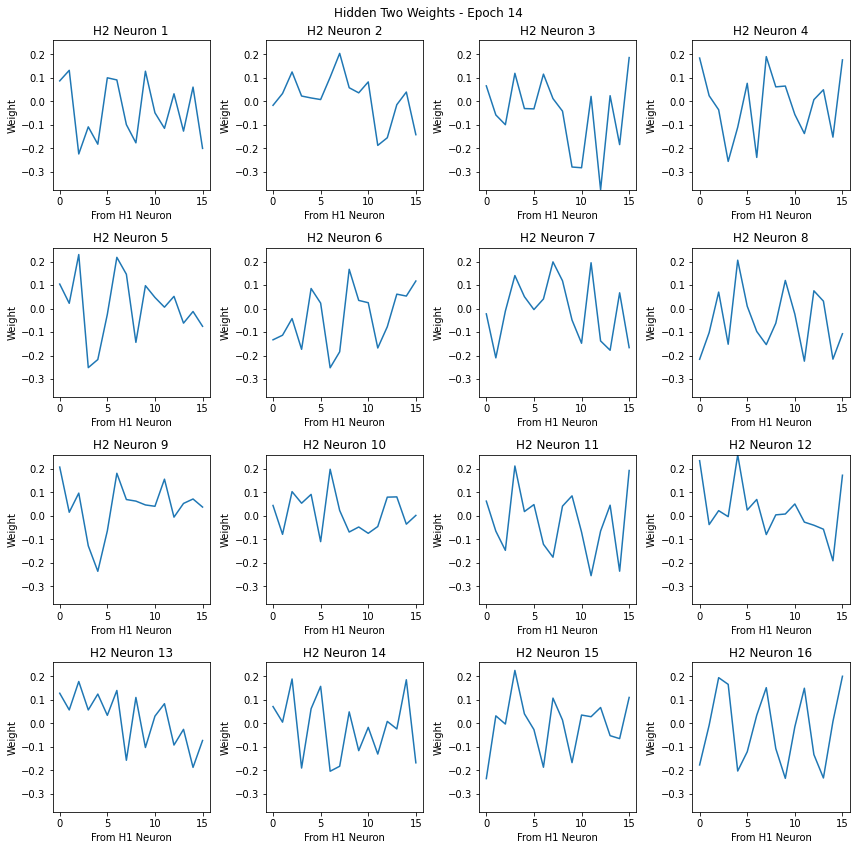

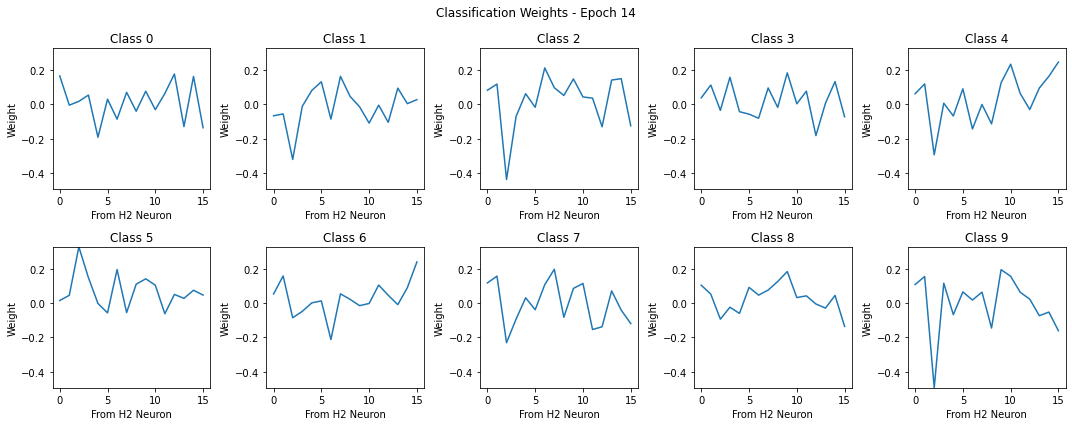

Epoch 15/20
  Train Loss: 0.3212
  SAE Train Loss (hidden one): 1.6390
  SAE Train Loss (hidden two): 0.1377
  Val Loss: 0.3651 | Val Acc: 89.16%


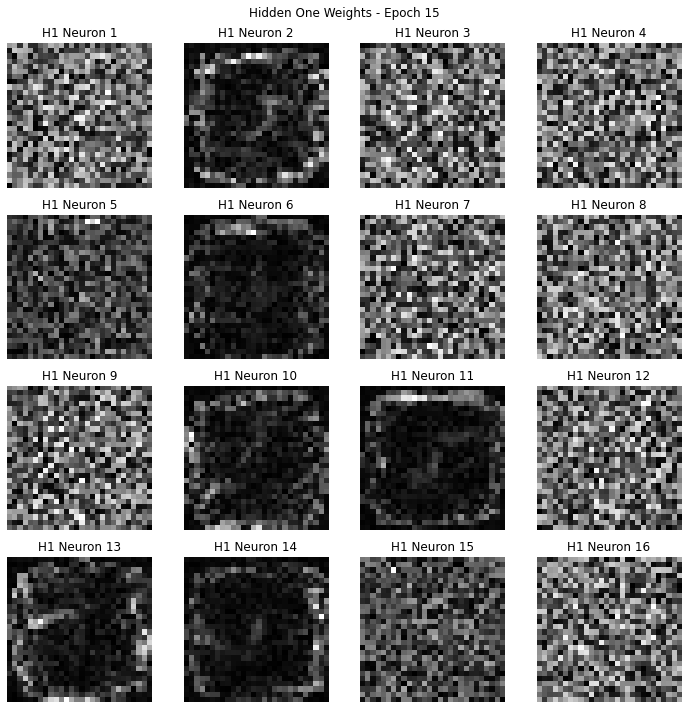

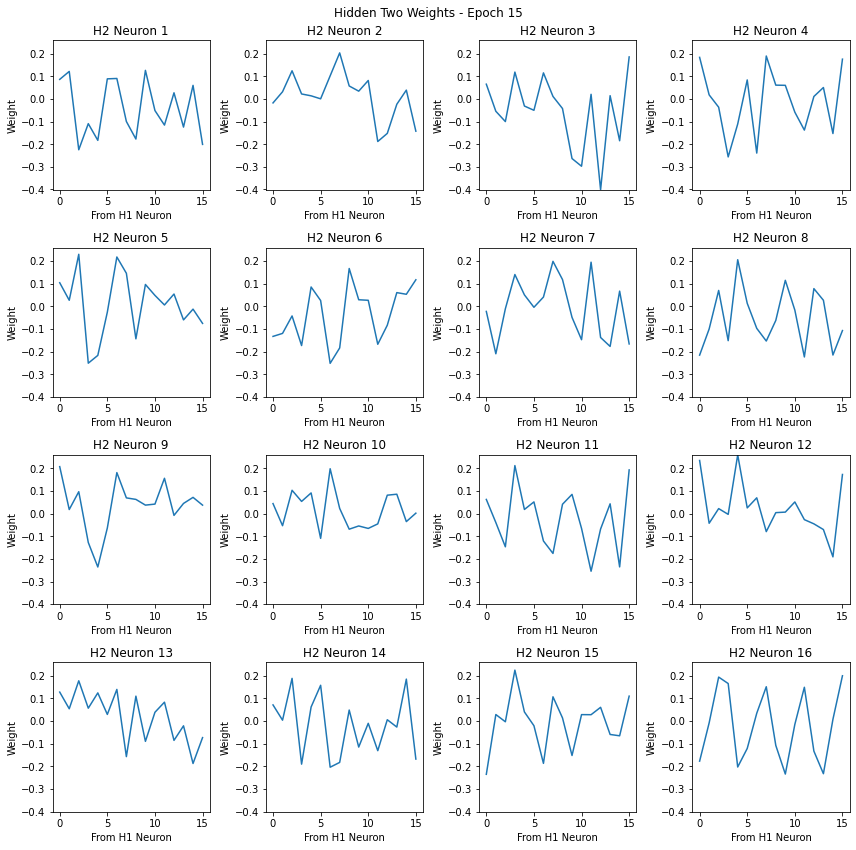

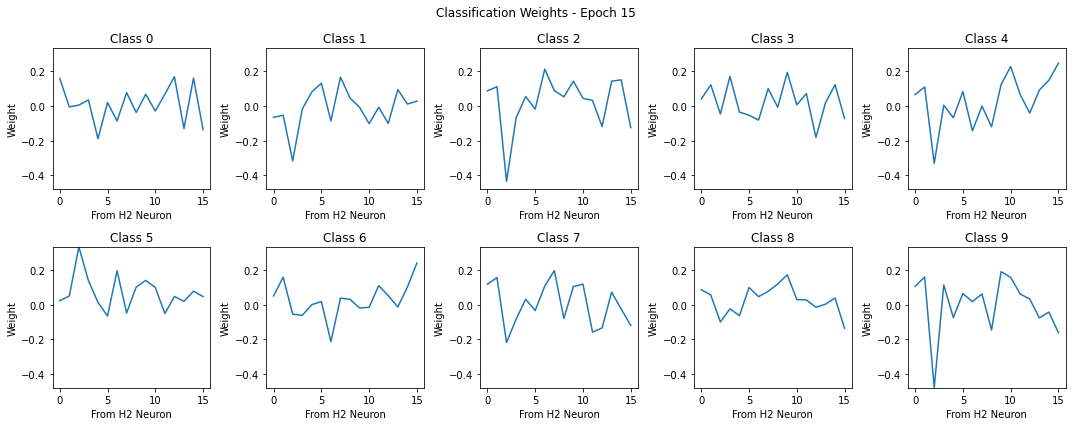

Epoch 16/20
  Train Loss: 0.3165
  SAE Train Loss (hidden one): 1.7006
  SAE Train Loss (hidden two): 0.1343
  Val Loss: 0.3507 | Val Acc: 89.55%
  Saved model with Val Acc: 89.55%


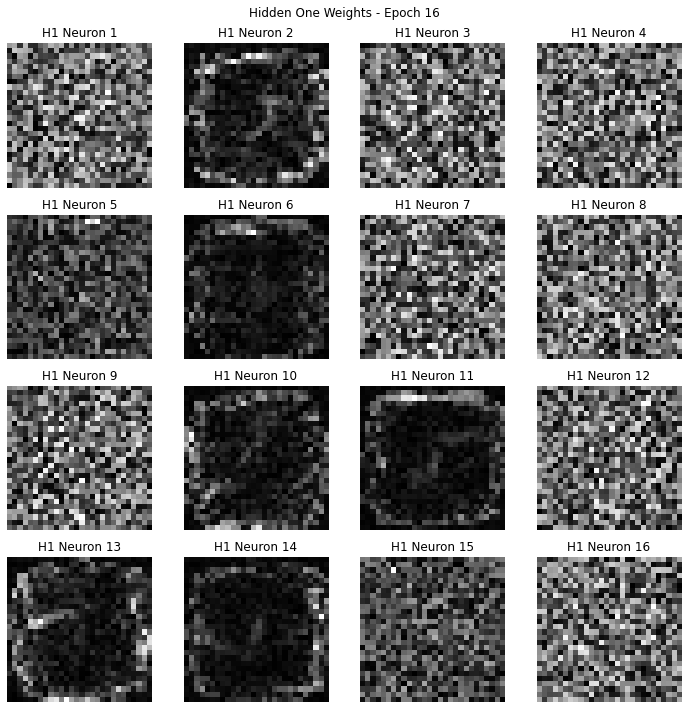

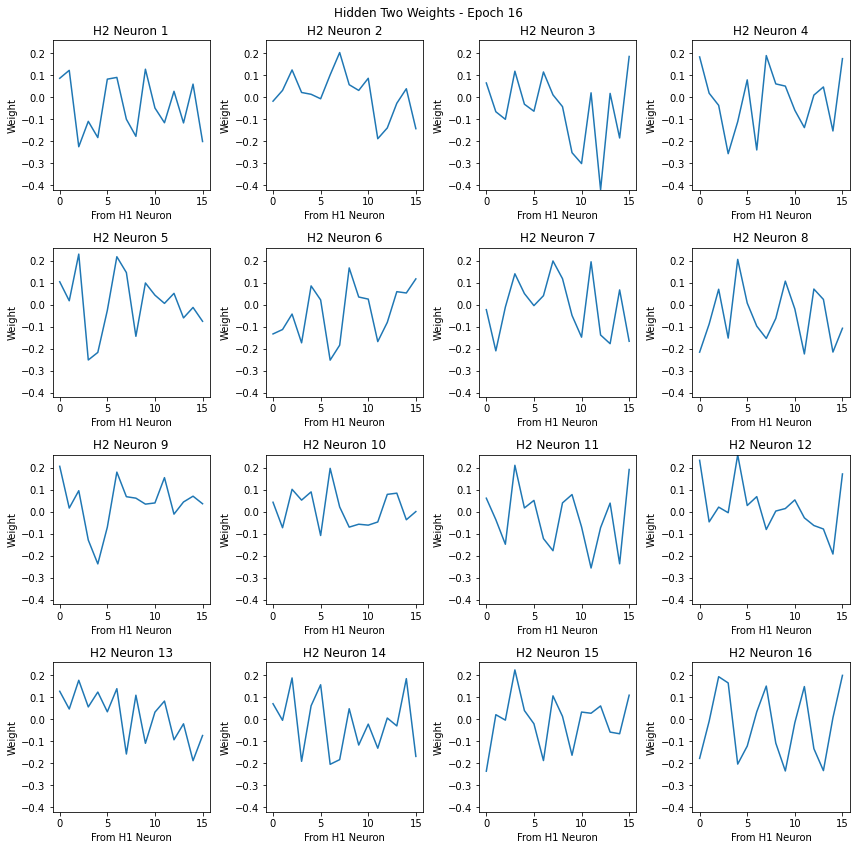

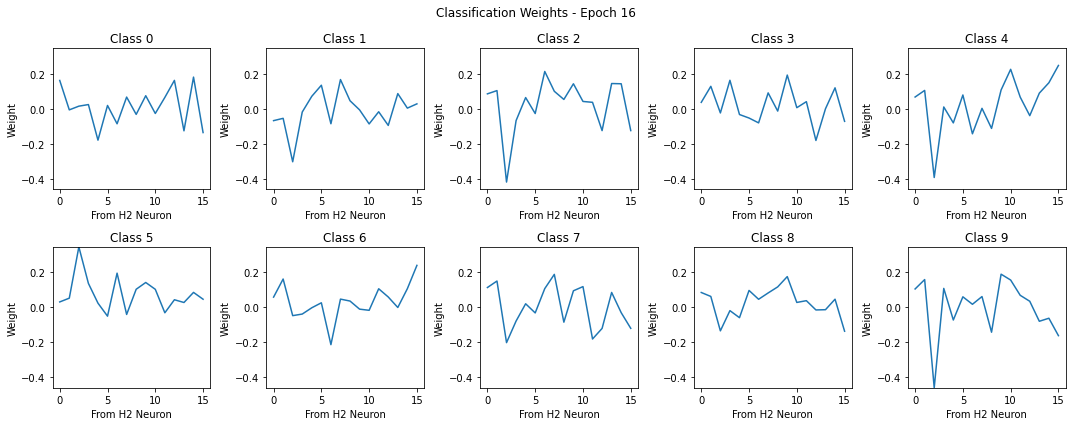

Epoch 17/20 [Train]:  28%|████████████▌                                | 218/782 [00:01<00:03, 171.96it/s, loss=0.294]

In [ ]:
best_model = None
best_sae_one = None
best_sae_two = None
num_epochs = 20

best_val_acc = 0.0
best_val_loss = float('inf')

validation_losses = []
training_losses = []
SAE_hidden_one_losses = []
SAE_hidden_two_losses = []
for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()  # set the model to training mode - this is currently a no-op
    sae_hidden_two.train()
    sae_hidden_one.train()
    
    train_loss = 0.0
    total_sae_loss_hidden_two = 0.0
    total_sae_loss_hidden_one = 0.0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]", leave=False)
    for batch in train_bar:
        # deconstruct batch items
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        
        # forward pass
        classification_out, hidden_act_one, hidden_act_two = model(images)

        # Classification loss and backprop
        optimizer.zero_grad()
        total_loss = classification_loss_fn(classification_out, labels)
        total_loss.backward()
        optimizer.step()
        train_loss += total_loss.item()
        train_bar.set_postfix(loss=total_loss.item())

        # to prevent backprop on both graphs:
        hidden_act_one_detached = hidden_act_one.detach()
        hidden_act_two_detached = hidden_act_two.detach()

        # SAE loss and backprop - hidden layer one
        optimizer_sae_hidden_one.zero_grad()
        reconstructed_one, encoded_one = sae_hidden_one(hidden_act_one_detached)
        sae_loss_hidden_one = sae_hidden_one.loss(hidden_act_one_detached,
                                                  reconstructed_one,
                                                  encoded_one,
                                                  l1_lambda=L1_PENALTY
                                                 )
        sae_loss_hidden_one.backward()
        optimizer_sae_hidden_one.step()
        total_sae_loss_hidden_one += sae_loss_hidden_one.item()
        
        # SAE loss and backprop - hidden layer two
        optimizer_sae_hidden_two.zero_grad()
        reconstructed_two, encoded_two = sae_hidden_two(hidden_act_two_detached)
        sae_loss_hidden_two = sae_hidden_two.loss(hidden_act_two_detached,
                                                  reconstructed_two,
                                                  encoded_two,
                                                  l1_lambda=L1_PENALTY
                                                 )
        sae_loss_hidden_two.backward()
        optimizer_sae_hidden_two.step()
        total_sae_loss_hidden_two += sae_loss_hidden_two.item()

    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for batch in val_bar:
            # deconstruct
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            # forward pass
            classification_out, _, _ = model(images)

            # compute loss
            loss = classification_loss_fn(classification_out, labels)

            # calculate metrics
            val_loss += loss.item()
            _, predicted = torch.max(classification_out, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # epoch stats
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    avg_sae_train_loss_hidden_one = total_sae_loss_hidden_one / len(train_loader)
    avg_sae_train_loss_hidden_two = total_sae_loss_hidden_two / len(train_loader)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  SAE Train Loss (hidden one): {avg_sae_train_loss_hidden_one:.4f}")
    print(f"  SAE Train Loss (hidden two): {avg_sae_train_loss_hidden_two:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    model_path = f'./models/{EXPERIMENT_TYPE}/{RUN_ID}/best_model_baseline_{epoch+1}.pth'
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        best_val_loss = avg_val_loss  # Update loss for reference
        torch.save(model.state_dict(), model_path)
        print(f"  Saved model with Val Acc: {val_accuracy:.2f}%")

        best_model = copy.deepcopy(model)
        best_sae_one = copy.deepcopy(sae_hidden_one)
        best_sae_two = copy.deepcopy(sae_hidden_two)
        
    # Optional: Save if accuracy is equal but loss is lower
    elif val_accuracy == best_val_acc and avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), model_path)
        print(f"  Saved model with same Val Acc: {val_accuracy:.2f}% but lower Val Loss: {avg_val_loss:.4f}")

        best_model = copy.deepcopy(model)
        best_sae_one = copy.deepcopy(sae_hidden_one)
        best_sae_two = copy.deepcopy(sae_hidden_two)

    validation_losses.append(avg_val_loss)
    training_losses.append(avg_train_loss)
    SAE_hidden_one_losses.append(avg_sae_train_loss_hidden_one)
    SAE_hidden_two_losses.append(avg_sae_train_loss_hidden_two)

    plot_weights(model, epoch, EXPERIMENT_TYPE, RUN_ID)

We have a lot of seemingly dead neurons. Poor for efficiency and likely performance, but also likely messes with out interpretability.

# Training Exploration

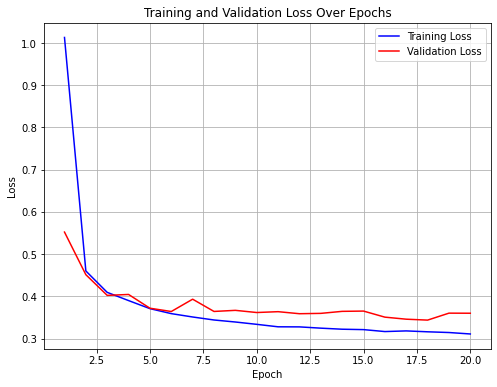

In [32]:
plot_losses(training_losses, validation_losses, label_one="Training", label_two="Validation")

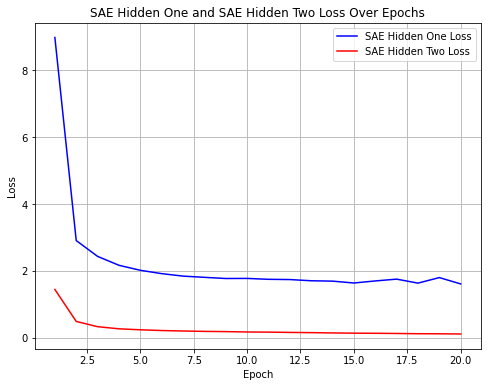

In [33]:
plot_losses(SAE_hidden_one_losses, SAE_hidden_two_losses, 
            label_one="SAE Hidden One", label_two="SAE Hidden Two")

SAEs **still** seem to stop learning really early... again... concerning. At least there is less noise in the training.

## Eval

Evaluating our classification model accuracy, in addition to the reconstruction and sparisty metrics of each SAE.

In [34]:
best_model.eval()  # again currently a no-op
best_sae_one.eval()
best_sae_two.eval()

test_correct = 0
test_total = 0

feature_activations_one_test = torch.zeros(HIDDEN_SIZE, len(test_images))
feature_activations_two_test = torch.zeros(HIDDEN_SIZE, len(test_images))
recon_errors_one = []
recon_errors_two = []

with torch.no_grad():
    test_bar = tqdm(test_loader, desc=f"Evaluation")
    for i, batch in enumerate(test_bar):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        # forward pass
        classification_out, hidden_one_act, hidden_two_act = best_model(images)
        reconstructed_one, encoded_one = best_sae_one(hidden_one_act)
        reconstructed_two, encoded_two = best_sae_two(hidden_two_act)

        # SAE reconstruction
        recon_errors_one.append(torch.mean((hidden_one_act - reconstructed_one) ** 2).item())
        recon_errors_two.append(torch.mean((hidden_two_act - reconstructed_two) ** 2).item())

        start_idx = i * test_loader.batch_size
        end_idx = start_idx + images.size(0)
        feature_activations_one_test[:, start_idx:end_idx] = encoded_one.T.cpu()
        feature_activations_two_test[:, start_idx:end_idx] = encoded_two.T.cpu()

        # stats
        _, predicted = torch.max(classification_out, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = 100 * test_correct / test_total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

# reconstruction accuracy of SAE at each layer
avg_recon_error_one = np.mean(recon_errors_one)
avg_recon_error_two = np.mean(recon_errors_two)
print(f"Average Reconstruction Error (Hidden One): {avg_recon_error_one:.4f}")
print(f"Average Reconstruction Error (Hidden Two): {avg_recon_error_two:.4f}")

# Compute sparsity (average non-zero features per image)
sparsity_one = torch.mean((feature_activations_one_test > 1e-5).float()).item() * 64
sparsity_two = torch.mean((feature_activations_two_test > 1e-5).float()).item() * 64
print(f"Average Non-Zero Features per Image (Hidden One): {sparsity_one:.2f}")
print(f"Average Non-Zero Features per Image (Hidden Two): {sparsity_two:.2f}")

Evaluation: 100%|████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 276.93it/s]

Final Test Accuracy: 90.42%
Average Reconstruction Error (Hidden One): 0.0696
Average Reconstruction Error (Hidden Two): 0.0180
Average Non-Zero Features per Image (Hidden One): 10.77
Average Non-Zero Features per Image (Hidden Two): 6.35


# SAE Feature Exploration

In [35]:
feature_activations_hidden_two = torch.zeros(HIDDEN_SIZE, len(train_images))
feature_activations_hidden_one = torch.zeros(HIDDEN_SIZE, len(train_images))

with torch.no_grad():
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)
        _, hidden_one_act, hidden_two_act = best_model(images)

        # hidden layer SAEs
        _, encoded_one = best_sae_one(hidden_one_act)
        _, encoded_two = best_sae_two(hidden_two_act)

        start_idx = i * train_loader.batch_size
        end_idx = start_idx + images.size(0)
        feature_activations_hidden_one[:, start_idx:end_idx] = encoded_one.T.cpu()
        feature_activations_hidden_two[:, start_idx:end_idx] = encoded_two.T.cpu()

## Particular Example

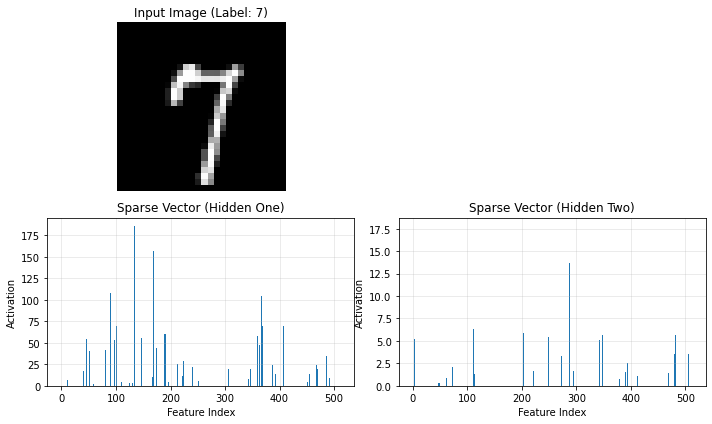

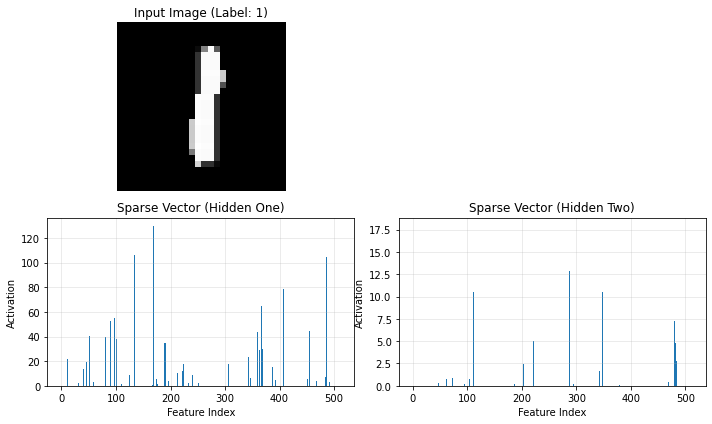

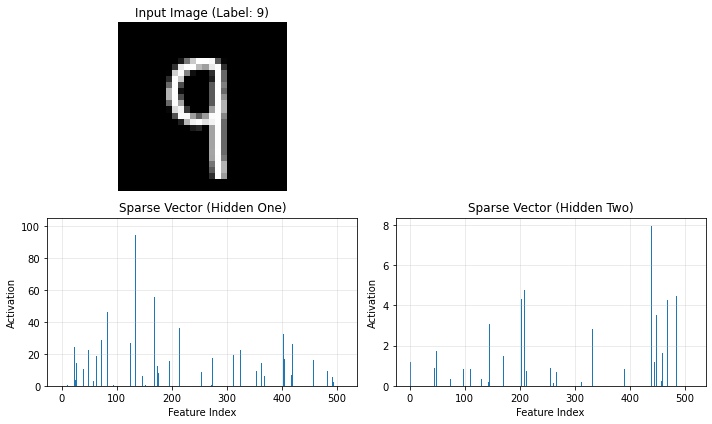

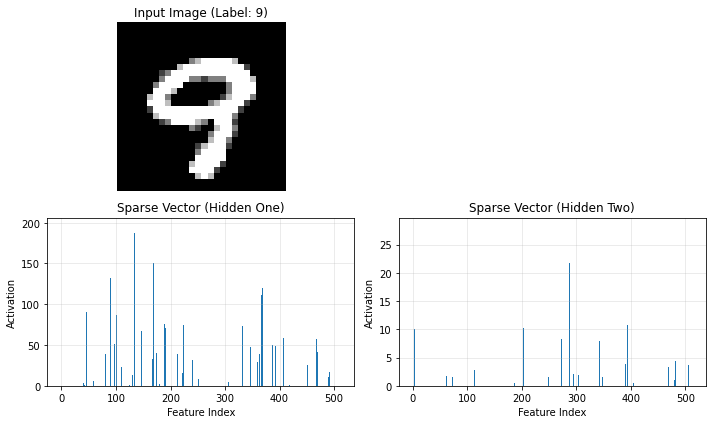

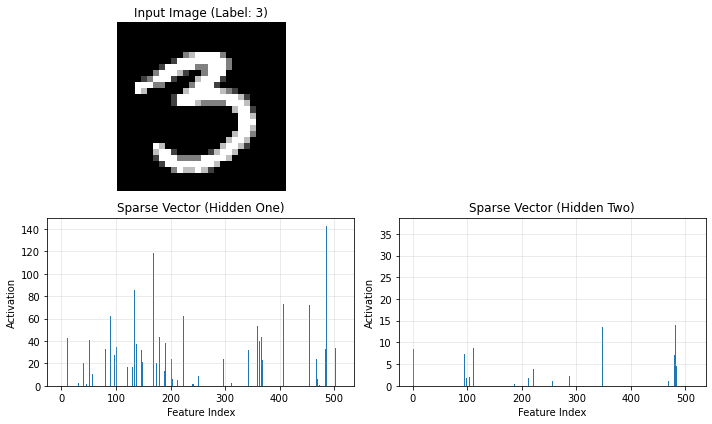

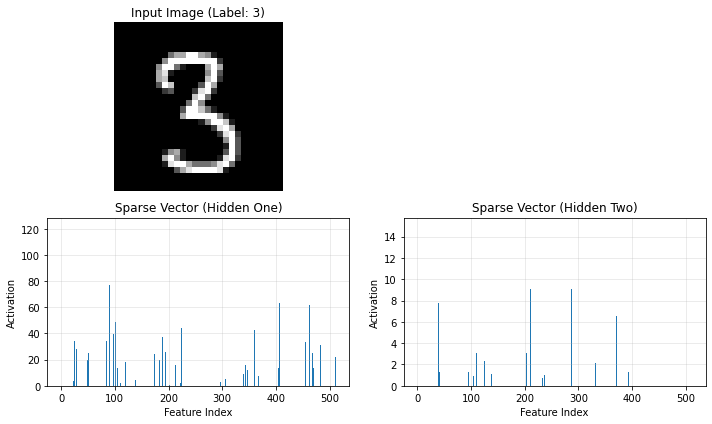

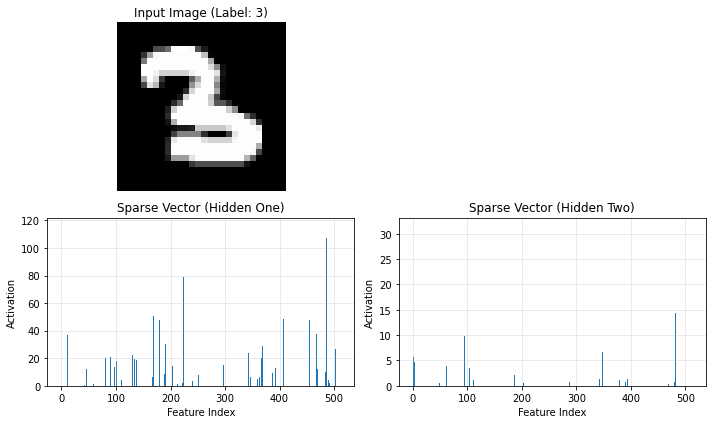

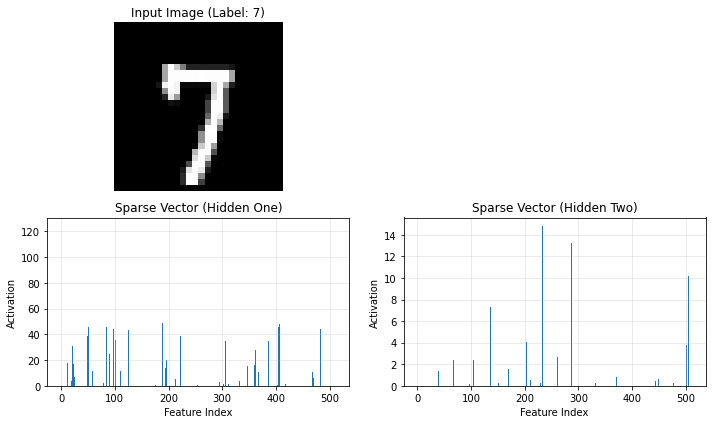

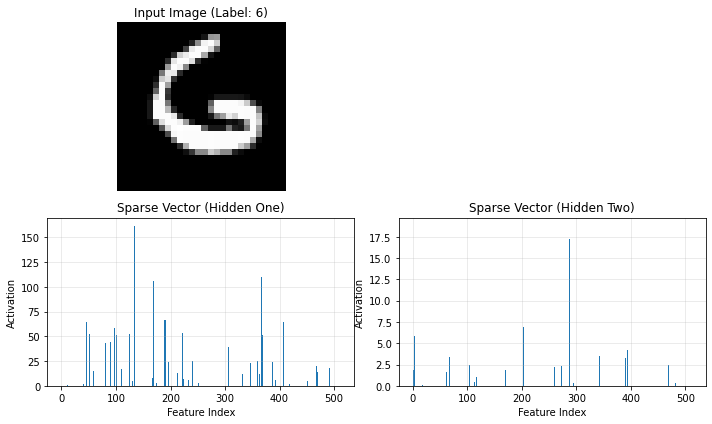

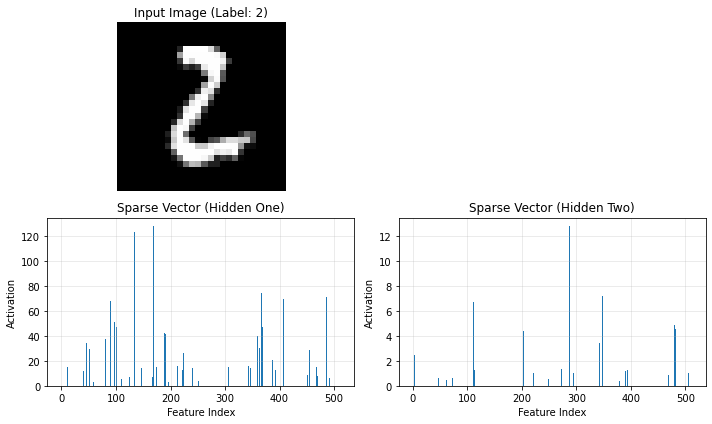

In [37]:
# image_idx = 0
for image_idx in range(0, 10):
    image, label = train_dataset[image_idx]
    
    encoded_one = feature_activations_hidden_one[:, image_idx].numpy()
    encoded_two = feature_activations_hidden_two[:, image_idx].numpy()
    
    plot_sparse_vecs_by_image(image, label, encoded_one, encoded_two)


Hidden One Feature-Class Associations:
Feature 1: Highest average activation for digit 0
Feature 2: Highest average activation for digit 0
Feature 3: Highest average activation for digit 0
Feature 4: Highest average activation for digit 0
Feature 5: Highest average activation for digit 0
Feature 6: Highest average activation for digit 0
Feature 7: Highest average activation for digit 0
Feature 8: Highest average activation for digit 4
Feature 9: Highest average activation for digit 0
Feature 10: Highest average activation for digit 0
Feature 11: Highest average activation for digit 0
Feature 12: Highest average activation for digit 8
Feature 13: Highest average activation for digit 4
Feature 14: Highest average activation for digit 0
Feature 15: Highest average activation for digit 0
Feature 16: Highest average activation for digit 0
Feature 17: Highest average activation for digit 4
Feature 18: Highest average activation for digit 0
Feature 19: Highest average activation for digit 4


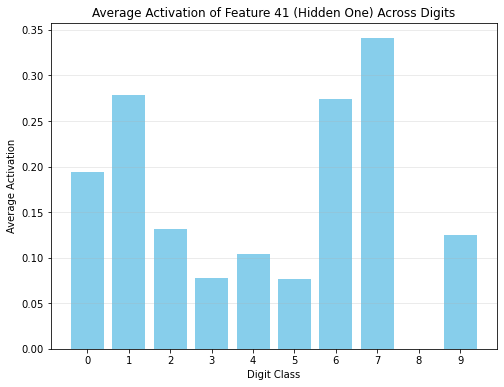

Feature 42: Highest average activation for digit 4
Feature 43: Highest average activation for digit 6
Feature 44: Highest average activation for digit 9
Feature 45: Highest average activation for digit 0
Feature 46: Highest average activation for digit 0
Feature 47: Highest average activation for digit 5
Feature 48: Highest average activation for digit 1
Feature 49: Highest average activation for digit 0
Feature 50: Highest average activation for digit 5
Feature 51: Highest average activation for digit 0
Feature 52: Highest average activation for digit 4
Feature 53: Highest average activation for digit 0
Feature 54: Highest average activation for digit 0
Feature 55: Highest average activation for digit 0
Feature 56: Highest average activation for digit 0
Feature 57: Highest average activation for digit 0
Feature 58: Highest average activation for digit 8
Feature 59: Highest average activation for digit 4
Feature 60: Highest average activation for digit 4
Feature 61: Highest average act

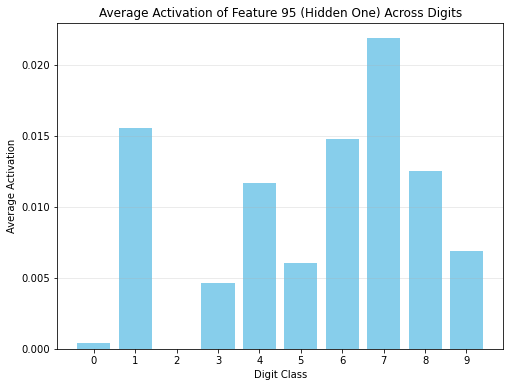

Feature 96: Highest average activation for digit 4
Feature 97: Highest average activation for digit 0
Feature 98: Highest average activation for digit 4
Feature 99: Highest average activation for digit 0
Feature 100: Highest average activation for digit 6
Feature 101: Highest average activation for digit 8
Feature 102: Highest average activation for digit 5
Feature 103: Highest average activation for digit 4
Feature 104: Highest average activation for digit 0
Feature 105: Highest average activation for digit 0
Feature 106: Highest average activation for digit 5
Feature 107: Highest average activation for digit 0
Feature 108: Highest average activation for digit 0
Feature 109: Highest average activation for digit 0
Feature 110: Highest average activation for digit 0
Feature 111: Highest average activation for digit 5
Feature 112: Highest average activation for digit 0
Feature 113: Highest average activation for digit 0
Feature 114: Highest average activation for digit 8
Feature 115: Hig

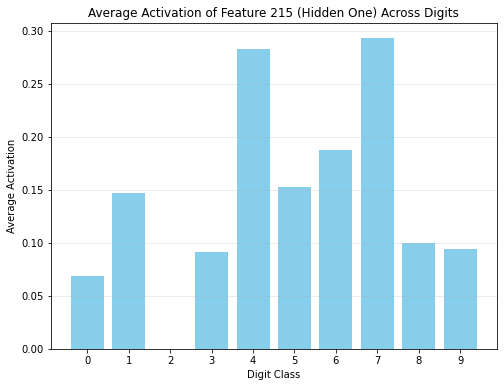

Feature 216: Highest average activation for digit 8
Feature 217: Highest average activation for digit 0
Feature 218: Highest average activation for digit 0
Feature 219: Highest average activation for digit 0
Feature 220: Highest average activation for digit 8
Feature 221: Highest average activation for digit 4
Feature 222: Highest average activation for digit 0
Feature 223: Highest average activation for digit 5
Feature 224: Highest average activation for digit 0
Feature 225: Highest average activation for digit 1
Feature 226: Highest average activation for digit 0
Feature 227: Highest average activation for digit 0
Feature 228: Highest average activation for digit 0
Feature 229: Highest average activation for digit 0
Feature 230: Highest average activation for digit 0
Feature 231: Highest average activation for digit 4
Feature 232: Highest average activation for digit 0
Feature 233: Highest average activation for digit 5
Feature 234: Highest average activation for digit 5
Feature 235:

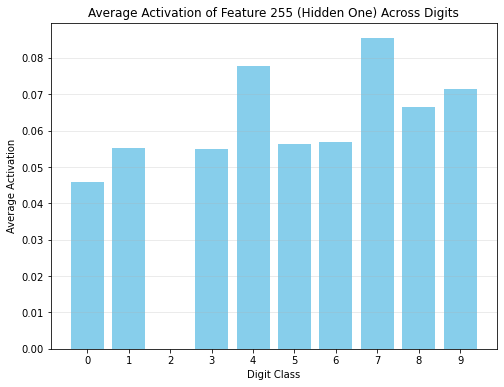

Feature 256: Highest average activation for digit 0
Feature 257: Highest average activation for digit 0
Feature 258: Highest average activation for digit 0
Feature 259: Highest average activation for digit 0
Feature 260: Highest average activation for digit 0
Feature 261: Highest average activation for digit 8
Feature 262: Highest average activation for digit 0
Feature 263: Highest average activation for digit 0
Feature 264: Highest average activation for digit 0
Feature 265: Highest average activation for digit 0
Feature 266: Highest average activation for digit 0
Feature 267: Highest average activation for digit 2
Feature 268: Highest average activation for digit 0
Feature 269: Highest average activation for digit 0
Feature 270: Highest average activation for digit 5
Feature 271: Highest average activation for digit 0
Feature 272: Highest average activation for digit 0
Feature 273: Highest average activation for digit 8
Feature 274: Highest average activation for digit 0
Feature 275:

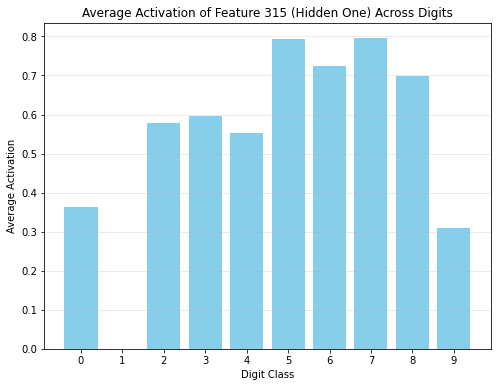

Feature 316: Highest average activation for digit 0
Feature 317: Highest average activation for digit 0
Feature 318: Highest average activation for digit 8
Feature 319: Highest average activation for digit 5
Feature 320: Highest average activation for digit 0
Feature 321: Highest average activation for digit 0
Feature 322: Highest average activation for digit 0
Feature 323: Highest average activation for digit 0
Feature 324: Highest average activation for digit 0
Feature 325: Highest average activation for digit 0
Feature 326: Highest average activation for digit 4
Feature 327: Highest average activation for digit 0
Feature 328: Highest average activation for digit 0
Feature 329: Highest average activation for digit 0
Feature 330: Highest average activation for digit 4
Feature 331: Highest average activation for digit 1
Feature 332: Highest average activation for digit 5
Feature 333: Highest average activation for digit 5
Feature 334: Highest average activation for digit 0
Feature 335:

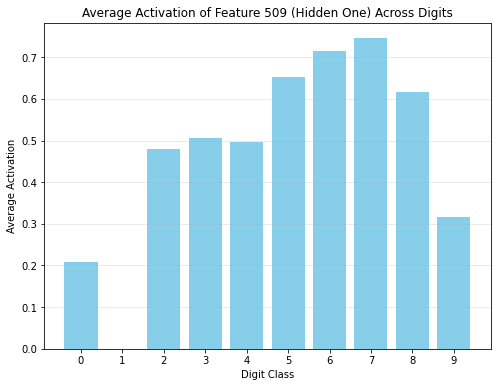

Feature 510: Highest average activation for digit 0
Feature 511: Highest average activation for digit 0
Feature 512: Highest average activation for digit 0

Hidden Two Feature-Class Associations:
Feature 1: Highest average activation for digit 0
Feature 2: Highest average activation for digit 2
Feature 3: Highest average activation for digit 8
Feature 4: Highest average activation for digit 5
Feature 5: Highest average activation for digit 3
Feature 6: Highest average activation for digit 0
Feature 7: Highest average activation for digit 4
Feature 8: Highest average activation for digit 0
Feature 9: Highest average activation for digit 1
Feature 10: Highest average activation for digit 4
Feature 11: Highest average activation for digit 0
Feature 12: Highest average activation for digit 9
Feature 13: Highest average activation for digit 3
Feature 14: Highest average activation for digit 5
Feature 15: Highest average activation for digit 0
Feature 16: Highest average activation for digit

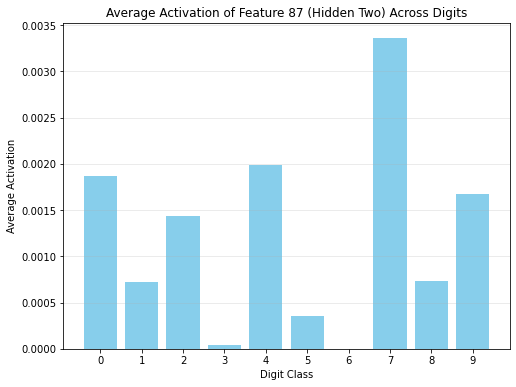

Feature 88: Highest average activation for digit 0
Feature 89: Highest average activation for digit 0
Feature 90: Highest average activation for digit 0
Feature 91: Highest average activation for digit 6
Feature 92: Highest average activation for digit 0
Feature 93: Highest average activation for digit 0
Feature 94: Highest average activation for digit 4
Feature 95: Highest average activation for digit 0
Feature 96: Highest average activation for digit 1
Feature 97: Highest average activation for digit 7


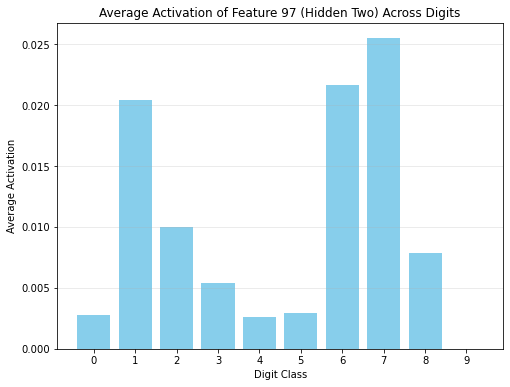

Feature 98: Highest average activation for digit 8
Feature 99: Highest average activation for digit 8
Feature 100: Highest average activation for digit 3
Feature 101: Highest average activation for digit 0
Feature 102: Highest average activation for digit 8
Feature 103: Highest average activation for digit 7
Feature 104: Highest average activation for digit 4
Feature 105: Highest average activation for digit 4
Feature 106: Highest average activation for digit 8
Feature 107: Highest average activation for digit 0
Feature 108: Highest average activation for digit 0
Feature 109: Highest average activation for digit 0
Feature 110: Highest average activation for digit 0
Feature 111: Highest average activation for digit 0
Feature 112: Highest average activation for digit 2
Feature 113: Highest average activation for digit 5
Feature 114: Highest average activation for digit 4
Feature 115: Highest average activation for digit 4
Feature 116: Highest average activation for digit 7


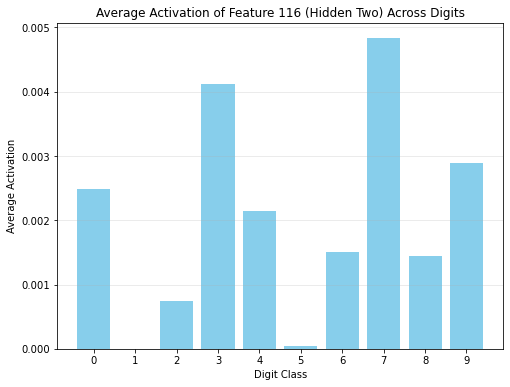

Feature 117: Highest average activation for digit 0
Feature 118: Highest average activation for digit 4
Feature 119: Highest average activation for digit 6
Feature 120: Highest average activation for digit 0
Feature 121: Highest average activation for digit 0
Feature 122: Highest average activation for digit 0
Feature 123: Highest average activation for digit 7


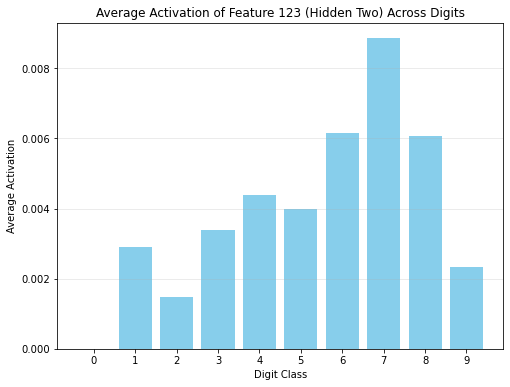

Feature 124: Highest average activation for digit 4
Feature 125: Highest average activation for digit 9
Feature 126: Highest average activation for digit 1
Feature 127: Highest average activation for digit 0
Feature 128: Highest average activation for digit 0
Feature 129: Highest average activation for digit 0
Feature 130: Highest average activation for digit 0
Feature 131: Highest average activation for digit 3
Feature 132: Highest average activation for digit 0
Feature 133: Highest average activation for digit 0
Feature 134: Highest average activation for digit 0
Feature 135: Highest average activation for digit 0
Feature 136: Highest average activation for digit 0
Feature 137: Highest average activation for digit 5
Feature 138: Highest average activation for digit 6
Feature 139: Highest average activation for digit 8
Feature 140: Highest average activation for digit 7


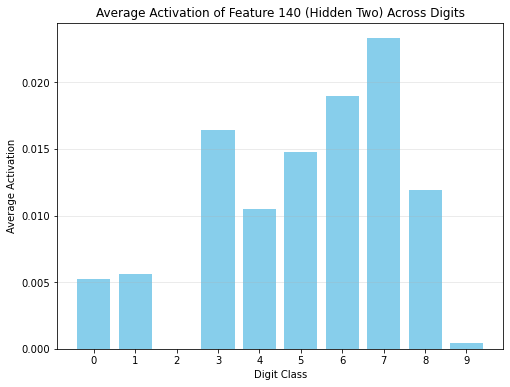

Feature 141: Highest average activation for digit 4
Feature 142: Highest average activation for digit 0
Feature 143: Highest average activation for digit 0
Feature 144: Highest average activation for digit 3
Feature 145: Highest average activation for digit 0
Feature 146: Highest average activation for digit 7


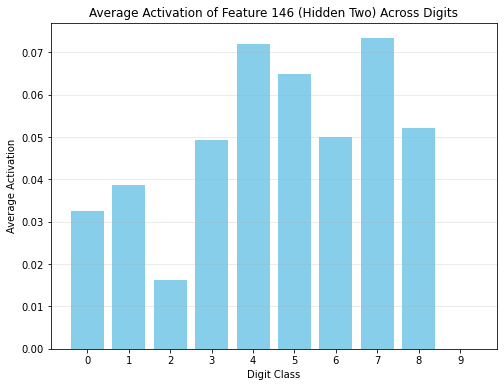

Feature 147: Highest average activation for digit 7
Feature 148: Highest average activation for digit 0
Feature 149: Highest average activation for digit 0
Feature 150: Highest average activation for digit 0
Feature 151: Highest average activation for digit 1
Feature 152: Highest average activation for digit 3
Feature 153: Highest average activation for digit 7
Feature 154: Highest average activation for digit 0
Feature 155: Highest average activation for digit 0
Feature 156: Highest average activation for digit 0
Feature 157: Highest average activation for digit 0
Feature 158: Highest average activation for digit 2
Feature 159: Highest average activation for digit 0
Feature 160: Highest average activation for digit 0
Feature 161: Highest average activation for digit 1
Feature 162: Highest average activation for digit 0
Feature 163: Highest average activation for digit 0
Feature 164: Highest average activation for digit 2
Feature 165: Highest average activation for digit 0
Feature 166:

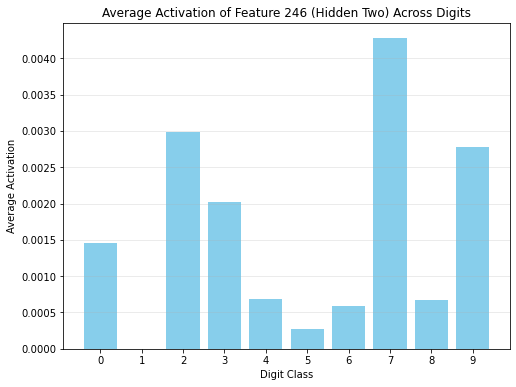

Feature 247: Highest average activation for digit 0
Feature 248: Highest average activation for digit 3
Feature 249: Highest average activation for digit 1
Feature 250: Highest average activation for digit 9
Feature 251: Highest average activation for digit 0
Feature 252: Highest average activation for digit 8
Feature 253: Highest average activation for digit 0
Feature 254: Highest average activation for digit 8
Feature 255: Highest average activation for digit 0
Feature 256: Highest average activation for digit 8
Feature 257: Highest average activation for digit 3
Feature 258: Highest average activation for digit 3
Feature 259: Highest average activation for digit 7
Feature 260: Highest average activation for digit 2
Feature 261: Highest average activation for digit 4
Feature 262: Highest average activation for digit 1
Feature 263: Highest average activation for digit 8
Feature 264: Highest average activation for digit 0
Feature 265: Highest average activation for digit 4
Feature 266:

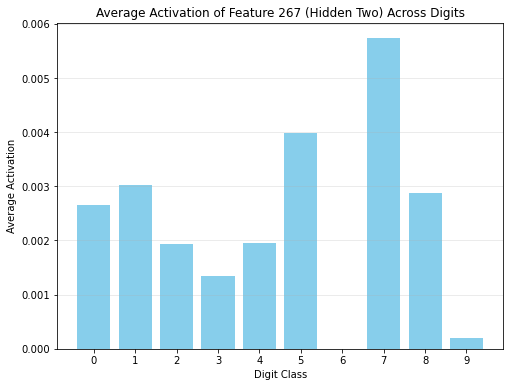

Feature 268: Highest average activation for digit 0
Feature 269: Highest average activation for digit 8
Feature 270: Highest average activation for digit 0
Feature 271: Highest average activation for digit 0
Feature 272: Highest average activation for digit 0
Feature 273: Highest average activation for digit 4
Feature 274: Highest average activation for digit 3
Feature 275: Highest average activation for digit 9
Feature 276: Highest average activation for digit 5
Feature 277: Highest average activation for digit 1
Feature 278: Highest average activation for digit 7
Feature 279: Highest average activation for digit 0
Feature 280: Highest average activation for digit 0
Feature 281: Highest average activation for digit 4
Feature 282: Highest average activation for digit 8
Feature 283: Highest average activation for digit 1
Feature 284: Highest average activation for digit 0
Feature 285: Highest average activation for digit 7


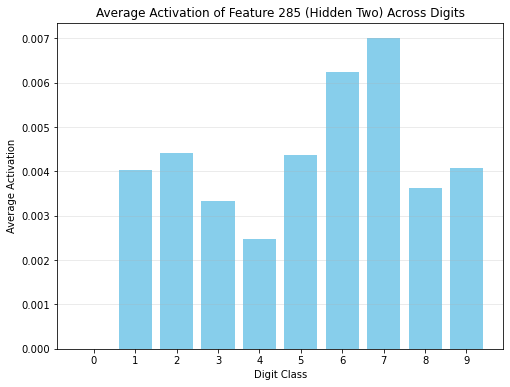

Feature 286: Highest average activation for digit 0
Feature 287: Highest average activation for digit 4
Feature 288: Highest average activation for digit 5
Feature 289: Highest average activation for digit 1
Feature 290: Highest average activation for digit 0
Feature 291: Highest average activation for digit 0
Feature 292: Highest average activation for digit 9
Feature 293: Highest average activation for digit 7


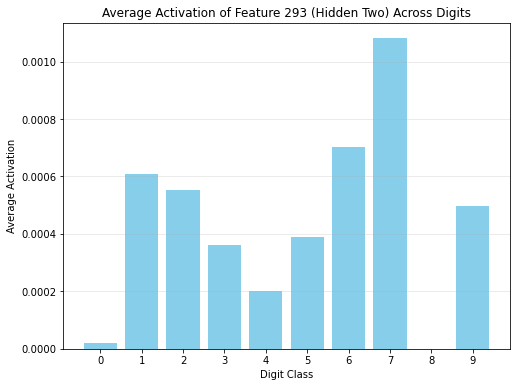

Feature 294: Highest average activation for digit 0
Feature 295: Highest average activation for digit 8
Feature 296: Highest average activation for digit 8
Feature 297: Highest average activation for digit 0
Feature 298: Highest average activation for digit 9
Feature 299: Highest average activation for digit 2
Feature 300: Highest average activation for digit 0
Feature 301: Highest average activation for digit 0
Feature 302: Highest average activation for digit 4
Feature 303: Highest average activation for digit 0
Feature 304: Highest average activation for digit 2
Feature 305: Highest average activation for digit 5
Feature 306: Highest average activation for digit 7
Feature 307: Highest average activation for digit 0
Feature 308: Highest average activation for digit 0
Feature 309: Highest average activation for digit 0
Feature 310: Highest average activation for digit 0
Feature 311: Highest average activation for digit 1
Feature 312: Highest average activation for digit 3
Feature 313:

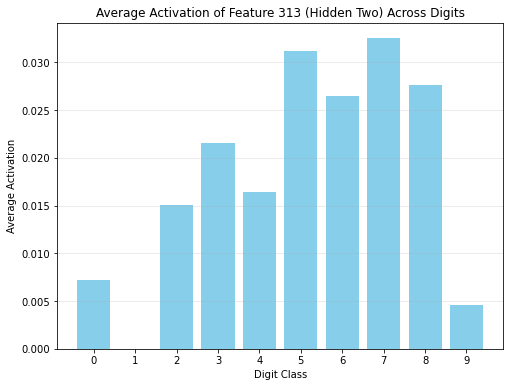

Feature 314: Highest average activation for digit 0
Feature 315: Highest average activation for digit 0
Feature 316: Highest average activation for digit 0
Feature 317: Highest average activation for digit 7
Feature 318: Highest average activation for digit 0
Feature 319: Highest average activation for digit 7
Feature 320: Highest average activation for digit 1
Feature 321: Highest average activation for digit 0
Feature 322: Highest average activation for digit 1
Feature 323: Highest average activation for digit 0
Feature 324: Highest average activation for digit 8
Feature 325: Highest average activation for digit 0
Feature 326: Highest average activation for digit 0
Feature 327: Highest average activation for digit 0
Feature 328: Highest average activation for digit 4
Feature 329: Highest average activation for digit 0
Feature 330: Highest average activation for digit 4
Feature 331: Highest average activation for digit 0
Feature 332: Highest average activation for digit 0
Feature 333:

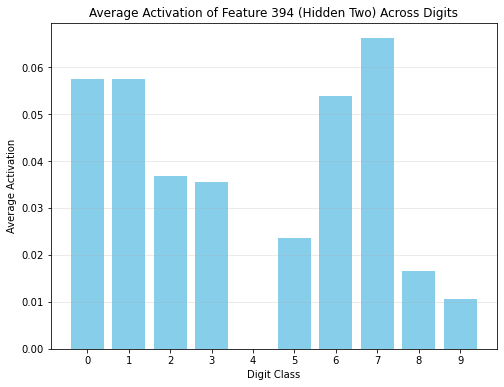

Feature 395: Highest average activation for digit 5
Feature 396: Highest average activation for digit 7
Feature 397: Highest average activation for digit 4
Feature 398: Highest average activation for digit 0
Feature 399: Highest average activation for digit 7
Feature 400: Highest average activation for digit 0
Feature 401: Highest average activation for digit 0
Feature 402: Highest average activation for digit 0
Feature 403: Highest average activation for digit 0
Feature 404: Highest average activation for digit 0
Feature 405: Highest average activation for digit 5
Feature 406: Highest average activation for digit 5
Feature 407: Highest average activation for digit 0
Feature 408: Highest average activation for digit 7


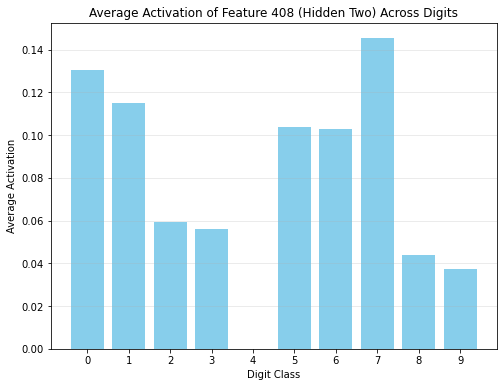

Feature 409: Highest average activation for digit 0
Feature 410: Highest average activation for digit 8
Feature 411: Highest average activation for digit 0
Feature 412: Highest average activation for digit 0
Feature 413: Highest average activation for digit 5
Feature 414: Highest average activation for digit 0
Feature 415: Highest average activation for digit 0
Feature 416: Highest average activation for digit 5
Feature 417: Highest average activation for digit 2
Feature 418: Highest average activation for digit 6
Feature 419: Highest average activation for digit 5
Feature 420: Highest average activation for digit 0
Feature 421: Highest average activation for digit 5
Feature 422: Highest average activation for digit 0
Feature 423: Highest average activation for digit 0
Feature 424: Highest average activation for digit 0
Feature 425: Highest average activation for digit 4
Feature 426: Highest average activation for digit 3
Feature 427: Highest average activation for digit 5
Feature 428:

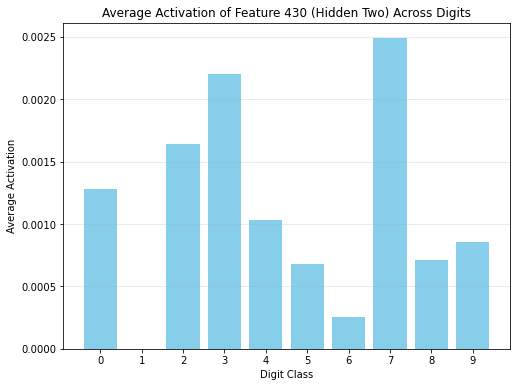

Feature 431: Highest average activation for digit 1
Feature 432: Highest average activation for digit 0
Feature 433: Highest average activation for digit 0
Feature 434: Highest average activation for digit 0
Feature 435: Highest average activation for digit 1
Feature 436: Highest average activation for digit 1
Feature 437: Highest average activation for digit 4
Feature 438: Highest average activation for digit 5
Feature 439: Highest average activation for digit 7
Feature 440: Highest average activation for digit 4
Feature 441: Highest average activation for digit 4
Feature 442: Highest average activation for digit 7


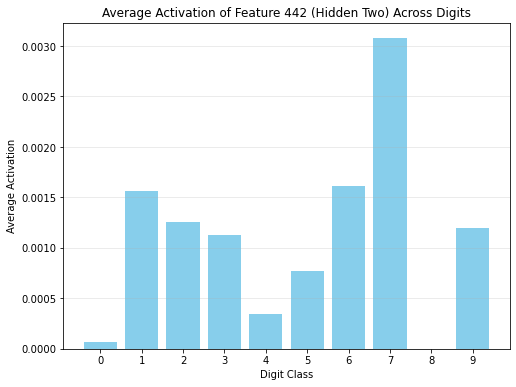

Feature 443: Highest average activation for digit 0
Feature 444: Highest average activation for digit 1
Feature 445: Highest average activation for digit 2
Feature 446: Highest average activation for digit 0
Feature 447: Highest average activation for digit 6
Feature 448: Highest average activation for digit 0
Feature 449: Highest average activation for digit 5
Feature 450: Highest average activation for digit 8
Feature 451: Highest average activation for digit 8
Feature 452: Highest average activation for digit 9
Feature 453: Highest average activation for digit 0
Feature 454: Highest average activation for digit 4
Feature 455: Highest average activation for digit 0
Feature 456: Highest average activation for digit 1
Feature 457: Highest average activation for digit 0
Feature 458: Highest average activation for digit 4
Feature 459: Highest average activation for digit 0
Feature 460: Highest average activation for digit 4
Feature 461: Highest average activation for digit 0
Feature 462:

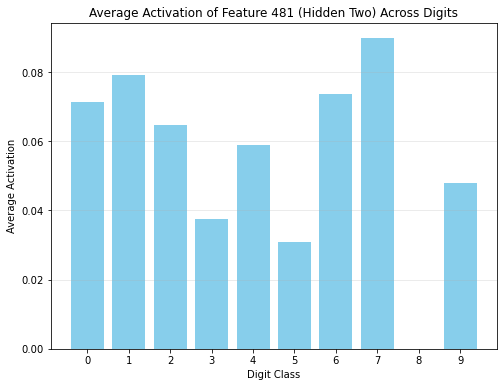

Feature 482: Highest average activation for digit 2
Feature 483: Highest average activation for digit 2
Feature 484: Highest average activation for digit 2
Feature 485: Highest average activation for digit 7


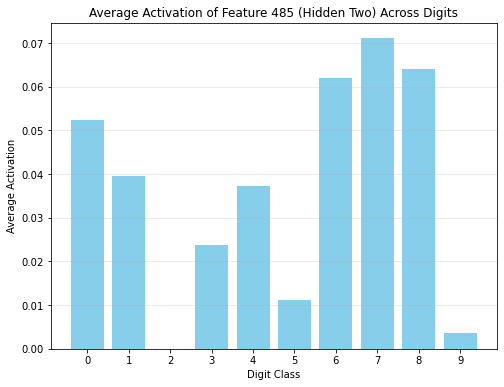

Feature 486: Highest average activation for digit 5
Feature 487: Highest average activation for digit 8
Feature 488: Highest average activation for digit 4
Feature 489: Highest average activation for digit 0
Feature 490: Highest average activation for digit 0
Feature 491: Highest average activation for digit 0
Feature 492: Highest average activation for digit 5
Feature 493: Highest average activation for digit 0
Feature 494: Highest average activation for digit 1
Feature 495: Highest average activation for digit 9
Feature 496: Highest average activation for digit 4
Feature 497: Highest average activation for digit 9
Feature 498: Highest average activation for digit 8
Feature 499: Highest average activation for digit 8
Feature 500: Highest average activation for digit 4
Feature 501: Highest average activation for digit 1
Feature 502: Highest average activation for digit 3
Feature 503: Highest average activation for digit 7
Feature 504: Highest average activation for digit 0
Feature 505:

In [38]:
labels = np.array([label for label in train_labels])
for layer_name, feature_activations in [("Hidden One", feature_activations_hidden_one),
                                        ("Hidden Two", feature_activations_hidden_two)]:
    print(f"\n{layer_name} Feature-Class Associations:")
    for feature_idx in range(HIDDEN_SIZE):
        activations = feature_activations[feature_idx].numpy()
        class_averages = [np.mean(activations[labels == c]) for c in range(10)]

        top_class = np.argmax(class_averages)

        print(f"Feature {feature_idx + 1}: Highest average activation for digit {top_class}")
        if top_class == 7 and max(class_averages) >= 0.001:
            plt.figure(figsize=(8, 6))
            class_averages_graph = class_averages - min(class_averages)
            plt.bar(range(10), class_averages_graph, tick_label=[str(i) for i in range(10)], color='skyblue')
            plt.title(f"Average Activation of Feature {feature_idx + 1} ({layer_name}) Across Digits")
            plt.xlabel("Digit Class")
            plt.ylabel("Average Activation")
            plt.grid(True, axis='y', alpha=0.3)
            plt.show()

## Top Activating Images By Feature

Feature 219 top 5 activations:


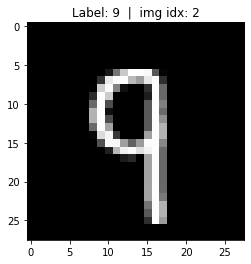

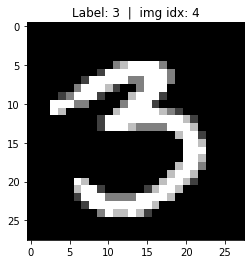

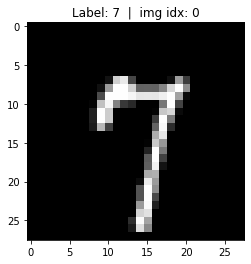

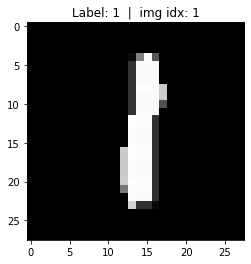

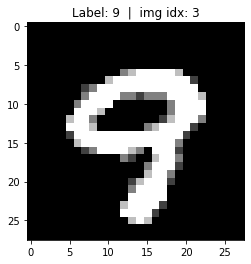

In [39]:
feature_idx = 219
feature_idx -= 1  # b/c we add one in visulazations above to start at 1

plot_top_act_images_by_feature(feature_idx,
                               feature_activations_hidden_one,
                               train_images,
                               train_labels,
                               top_k=5
                              )

Feature 91 top 5 activations:


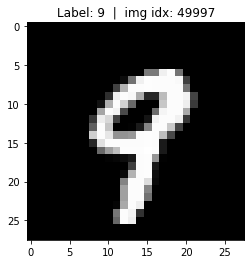

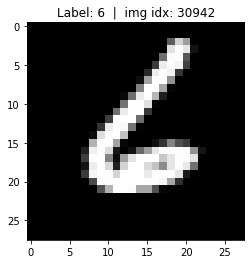

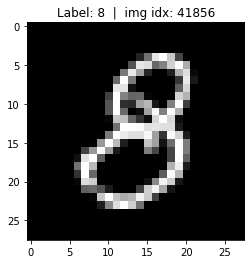

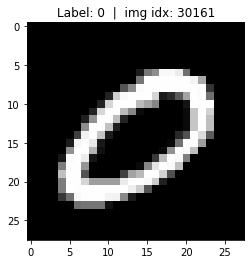

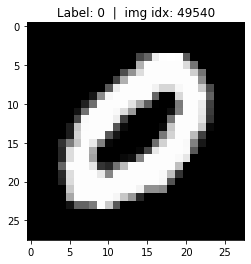

In [40]:
feature_idx = 91
feature_idx -= 1  # b/c we add one in visulazations above to start at 1

plot_top_act_images_by_feature(feature_idx,
                               feature_activations_hidden_two,
                               train_images,
                               train_labels,
                               top_k=5
                              )

This makes me a little optimistic we are trending in the right direction. It is a brief glance, but the top k seem more similar, or at least portions of the digit are similar.

## Saliency Maps

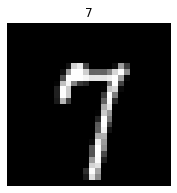

In [41]:
image, label = train_dataset[0]
visualize_image(image, label.item())

/Users/alexbishka/Documents/Projects/ml-fun/mnist-mech-interp/SAEs/graph_helpers.py:118: RuntimeWarning: invalid value encountered in divide
  saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())
/Users/alexbishka/opt/anaconda3/lib/python3.9/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/Users/alexbishka/opt/anaconda3/lib/python3.9/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


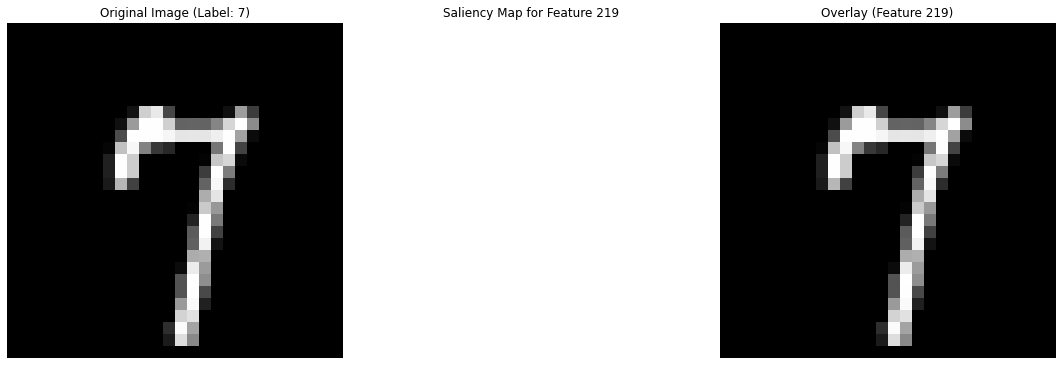

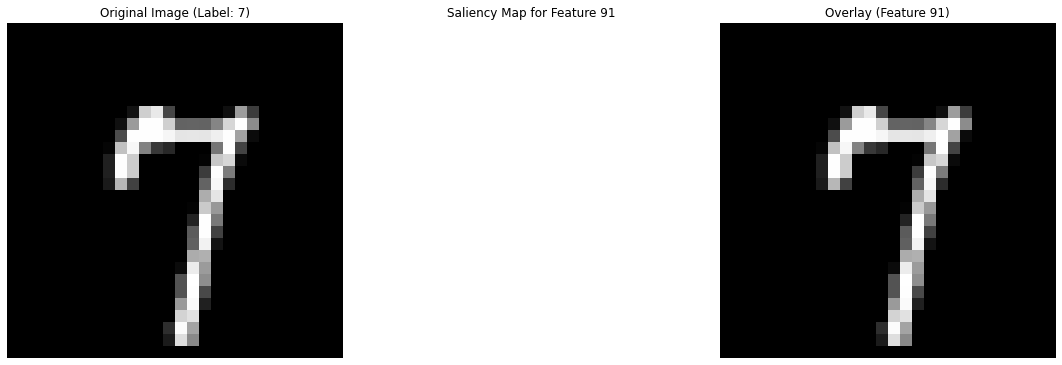

In [42]:
img_idx = 0
feature_idx = 219
feature_idx -= 1
plot_saliency_map(img_idx, feature_idx, best_model, best_sae_one, train_dataset, HIDDEN_SIZE, device, use_hidden_one=True)

img_idx = 0
feature_idx = 91
feature_idx -= 1
plot_saliency_map(img_idx, feature_idx, best_model, best_sae_two, train_dataset, HIDDEN_SIZE, device, use_hidden_one=False)

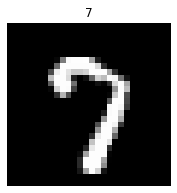

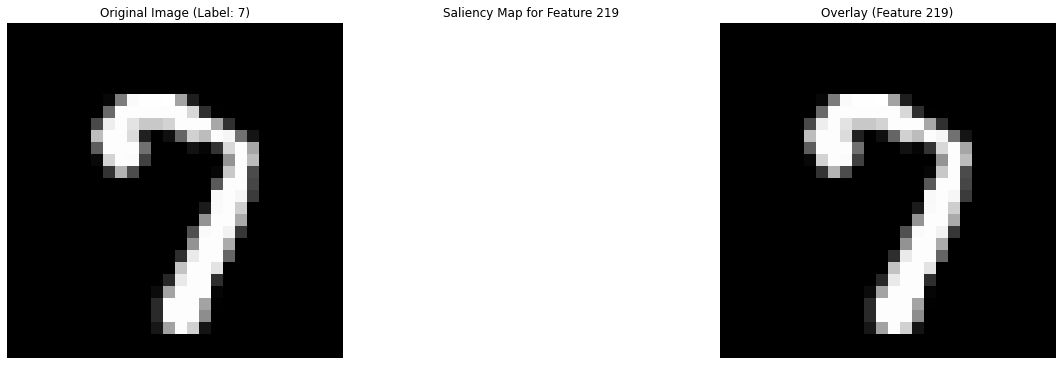

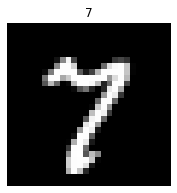

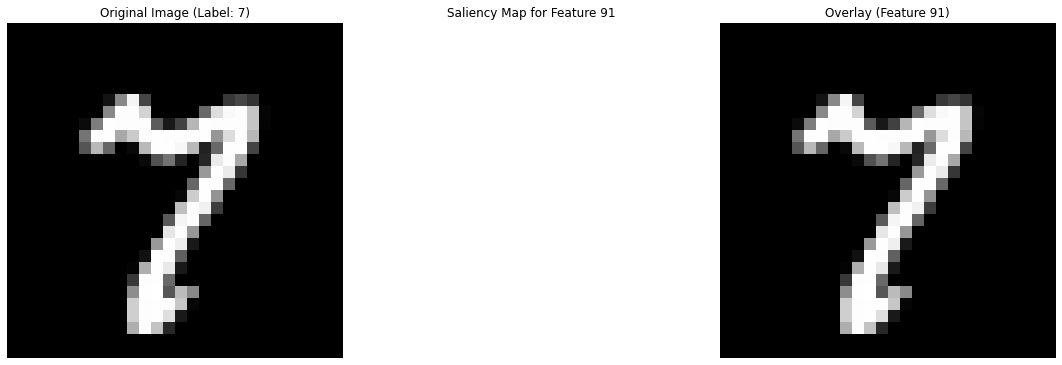

In [43]:
img_idx = 41012
image, label = train_dataset[img_idx]
visualize_image(image, label.item())

feature_idx = 219
feature_idx -= 1
plot_saliency_map(img_idx, feature_idx, best_model, best_sae_one, train_dataset, HIDDEN_SIZE, device, use_hidden_one=True)

img_idx = 4830
image, label = train_dataset[img_idx]
visualize_image(image, label.item())

feature_idx = 91
feature_idx -= 1
plot_saliency_map(img_idx, feature_idx, best_model, best_sae_two, train_dataset, HIDDEN_SIZE, device, use_hidden_one=False)

# Sparse Space Exploration

Seeing what a specific sparse feature that is maximally activated looks like (or perhaps more accurately, what image would likely trigger it to fire)

In [ ]:
image = torch.randn(1, 1, 28, 28, device=device, requires_grad=True)
sparse_optimizer = torch.optim.Adam([image], lr=0.1)

for _ in range(100):  # Iterate to optimize
    best_model.zero_grad()
    sae_hidden_one.zero_grad()
    _, hidden_one_act, hidden_two_act = best_model(image)
    _, encoded = best_sae_two(hidden_one_act)
    loss = -encoded[0, feature_idx]  # Maximize the feature
    loss.backward()
    sparse_optimizer.step()

    image.data = torch.clamp(image.data, 0, 1)

# Get the final encoding
with torch.no_grad():
    _, hidden_one_act_final, hidden_two_act_final = best_model(image)
    _, encoded_final = best_sae_two(hidden_two_act_final)

plt.figure(figsize=(6, 20))

# Visualize the generated image
plt.subplot(1, 2, 1)
plt.imshow(image.detach().cpu().numpy().squeeze(), cmap='gray')
plt.title(f"Image Maximizing Feature {feature_idx + 1}")
plt.axis('off')
plt.show()

# Visualize the encoding as a bar graph
plt.subplot(2, 1, 1)
feature_activations = encoded_final[0].cpu().numpy()
plt.bar(range(len(feature_activations)), feature_activations, color='skyblue')
plt.axvline(x=feature_idx, color='red', linestyle='--', label=f'Feature {feature_idx + 1}')
plt.title(f"Encoding Activations (Target: Feature {feature_idx + 1})")
plt.xlabel("Feature Index")
plt.ylabel("Activation Value")
plt.legend()
plt.xticks(range(0, len(feature_activations), 10))  # Show every 10th tick for clarity
plt.tight_layout()
plt.show()

Our maximally activated sparse feature is rarely maximally activated. I think our sparse autoencoder needs better settings.

# Activation Exploration

### Averaging Across All Activations

In [ ]:
layers = ["hidden_one", "hidden_two", "classification_out"]
def get_avg_layer(label, layer, act, stor_dict):
    if label in stor_dict:
        cur = avg_act_num_dict[label][layer]
        cur.append(act)
        avg_act_num_dict[label][layer] = cur

    else:
        avg_act_num_dict[label] = {}
        avg_act_num_dict[label][layer] = [act]

        for l in layers:
            if l != layer:
                avg_act_num_dict[label][l] = []
        
    return stor_dict

In [ ]:
avg_act_num_dict = {}
with torch.no_grad():
    for i in range(len(test_labels)):
        image = image = torch.from_numpy(test_images[i]).float().unsqueeze(0)
        label = test_labels[i]

        # Move to device
        image = image.to(device)

        # Forward pass
        classification_out, hidden_one_act, hidden_two_act = best_model(image)

        # Get predicted class
        _, predicted = torch.max(classification_out, 1)
        predicted = predicted.item()

        layer = "hidden_one"
        avg_act_num_dict = get_avg_layer(label, layer, hidden_one_act, avg_act_num_dict)

        layer = "hidden_two"
        avg_act_num_dict = get_avg_layer(label, layer, hidden_two_act, avg_act_num_dict)

        layer = "classification_out"
        avg_act_num_dict = get_avg_layer(label, layer, classification_out, avg_act_num_dict)

In [ ]:
for label in avg_act_num_dict.keys():
    for layer in avg_act_num_dict[label].keys():
        acts = torch.cat(avg_act_num_dict[label][layer], dim=0)
        avg_act = torch.mean(acts, dim=0)

        avg_act_num_dict[label][layer] = avg_act

In [ ]:
avg_act_num_dict[0]

In [ ]:
for num in avg_act_num_dict.keys():
    hidden_one_act = avg_act_num_dict[num]["hidden_one"]
    hidden_two_act = avg_act_num_dict[num]["hidden_two"]
    classification_out = avg_act_num_dict[num]["classification_out"]

    plot_activations(hidden_one_act, hidden_two_act, classification_out, num)

## Seeing Specific Activations

In [ ]:
with torch.no_grad():
    for i in range(10):
        # Get single image and label
        image = torch.from_numpy(test_images[i]).float().unsqueeze(0)
        label = test_labels[i]

        # Move to device
        image = image.to(device)

        # Forward pass
        classification_out, hidden_one_act, hidden_two_act = best_model(image)

        # Get predicted class
        _, predicted = torch.max(classification_out, 1)
        predicted = predicted.item()

        # Print results
        print(f"Image {i+1}: True Label = {label}, Predicted Label = {predicted}")

        plot_activations(hidden_one_act, hidden_two_act, classification_out, label)

In [ ]:
idx = 0

image_np = test_images[idx]
image_np_filt = np.where(image_np >= 180, image_np, 0)

image = torch.from_numpy(image_np).float().unsqueeze(0)
image_filt = torch.from_numpy(image_np_filt).float().unsqueeze(0)
label = test_labels[idx]

visualize_image(image_np, label)
visualize_image(image_np_filt, label)

In [ ]:
images = [image, image_filt]
with torch.no_grad():
    for i, img in enumerate(images):
        # Move to device
        img = img.to(device)
        
        # Forward pass
        classification_out, hidden_one_act, hidden_two_act = best_model(img)
        
        # Get predicted class
        _, predicted = torch.max(classification_out, 1)
        predicted = predicted.item()

        meta = "normal"
        if i != 0:
            meta = "sharpened"

        # Print results
        print(f"Image: True Label = {label}, Predicted Label = {predicted}, Meta = {meta}")
        
        plot_activations(hidden_one_act, hidden_two_act, classification_out, label, False)